# deprecated

In [ ]:
def unwrap_old(wrapped):
    low_prev = wrapped[200][200]
    high_prev = wrapped[200][200]
    low_scales = 0
    high_scales = 0
    for i in range(201):
        left_scales = 0
        right_scales = 0
        wrapped[i+200][200] += high_scales*2*np.pi
        if abs(wrapped[i+200][200] - high_prev) > np.pi/2:
            high_scales += 1;
            wrapped[i+200][200] += 2*np.pi
        high_prev = wrapped[i+200][200]
        left_prev = wrapped[i+200][200]
        right_prev = wrapped[i+200][200]
        for j in range(200):
            wrapped[i+200][j+201] += 2*np.pi*(right_scales + high_scales)
            if abs(wrapped[i+200][j+201] - right_prev) > np.pi/2:
                right_scales += 1
                wrapped[i+200][j+201] += 2*np.pi
            right_prev = wrapped[i+200][j+201]
            
            wrapped[i+200][199-j] += 2*np.pi*(left_scales + high_scales) 
            if abs(wrapped[i+200][199-j] - left_prev) > np.pi/2:
                left_scales += 1
                wrapped[i+200][199-j] += 2*np.pi
            left_prev = wrapped[i+200][199-j]
    for i in range(200):
        left_scales = 0
        right_scales = 0
        wrapped[199-i][200] += low_scales*2*np.pi
        if abs(wrapped[199-i][200] - low_prev) > np.pi/2:
            low_scales += 1;
            wrapped[199-i][200] += 2*np.pi
        low_prev = wrapped[199-i][200]
        left_prev = wrapped[199-i][200]
        right_prev = wrapped[199-i][200]
        for j in range(200):
            wrapped[199-i][j+201] += 2*np.pi*(right_scales + low_scales)
            if abs(wrapped[199-i][j+201] - right_prev) > np.pi/2:
                right_scales += 1
                wrapped[199-i][j+201] += 2*np.pi
            right_prev = wrapped[199-i][j+201]
            
            wrapped[199-i][199-j] += 2*np.pi*(left_scales + low_scales) 
            if abs(wrapped[199-i][199-j] - left_prev) > np.pi/2:
                left_scales += 1
                wrapped[199-i][199-j] += 2*np.pi
            left_prev = wrapped[199-i][199-j]

# init

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib import cm
import plotly
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import pandas as pd
import copy
from skspatial.objects import Plane, Point, Vector
pio.renderers.default = 'iframe' # or 'colab' or 'jupyterlab' or 'notebook'
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib import cm
import plotly
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import pandas as pd
import copy
from skspatial.objects import Plane, Point, Vector
pio.renderers.default = 'iframe' # or 'colab' or 'jupyterlab' or 'notebook'

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
from platform import python_version
print(python_version())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

3.12.0
Num GPUs Available:  0


In [3]:
def unwrap(phase):
    wrapped = np.copy(phase)
    vertical_prev = wrapped[0][0]
    vertical_scales = 0
    for i in range(len(wrapped)):
        horizontal_scales = 0
        wrapped[i][0] += vertical_scales*2*np.pi
        if wrapped[i][0] - vertical_prev > 1.5*np.pi:
            vertical_scales -= 1
            wrapped[i][0] -= 2*np.pi
        elif wrapped[i][0] - vertical_prev < -1.5*np.pi:
            vertical_scales += 1
            wrapped[i][0] += 2*np.pi
        vertical_prev = wrapped[i][0]
        horizontal_prev = wrapped[i][0]
        for j in range(1, len(wrapped)):
            wrapped[i][j] += 2*np.pi*(horizontal_scales + vertical_scales)
            if wrapped[i][j] - horizontal_prev > 1.5*np.pi:
                horizontal_scales -= 1
                wrapped[i][j] -= 2*np.pi
            elif wrapped[i][j] - horizontal_prev < -1.5*np.pi:
                horizontal_scales += 1
                wrapped[i][j] += 2*np.pi
            horizontal_prev = wrapped[i][j]
    return wrapped

def unwrap_new(phase):
    wrapped = np.copy(phase)
    vertical_prev = wrapped[0][0]
    vertical_scales = 0
    up_count = 0
    down_count = 0
    for i in range(len(wrapped)):
        horizontal_scales = 0
        wrapped[i][0] += vertical_scales*2*np.pi
        if wrapped[i][0] - vertical_prev > np.pi and down_count == 0:
            down_count += 1
            up_count = 0
            vertical_scales -= 1
            wrapped[i][0] -= 2*np.pi
        elif wrapped[i][0] - vertical_prev < -np.pi and up_count == 0:
            up_count += 1
            down_count = 0
            vertical_scales += 1
            wrapped[i][0] += 2*np.pi
        vertical_prev = wrapped[i][0]
        horizontal_prev = wrapped[i][0]
        for j in range(1, len(wrapped)):
            wrapped[i][j] += 2*np.pi*(horizontal_scales + vertical_scales)
            if wrapped[i][j] - horizontal_prev > np.pi:
                horizontal_scales -= 1
                wrapped[i][j] -= 2*np.pi
            elif wrapped[i][j] - horizontal_prev < -np.pi:
                horizontal_scales += 1
                wrapped[i][j] += 2*np.pi
            horizontal_prev = wrapped[i][j]
    return wrapped

def median_filter(data):
    window = np.empty([3, 3])
    data_extended = np.copy(data)
    data_extended = np.pad(data_extended, ((1, 1), (1, 1)), 'edge')
    for i in range(len(data)):
        for j in range(len(data)):
            for iw in range(3):
                for jw in range(3):
                    window[iw][jw] = data_extended[i + iw][j + jw]
            data[i][j] = np.median(window)

def rmse(error_map):
    quad_error = np.copy(error_map)
    quad_error = quad_error ** 2
    return np.sqrt(np.mean(quad_error))

def normalize_matrix(matrix):
    matrix_copy = copy.deepcopy(matrix)
    for vector in matrix_copy:
        length = np.sqrt(sum(number**2 for number in vector))
        for i in range(vector.size):
            vector[i] = vector[i] / length
    return matrix_copy

def projection(P, O_point, S_point, number_of_points):
    # Нормаль на плоскость
    directional_vector = np.array([(S_point[0] - O_point[0]), (S_point[1] - O_point[1]), (S_point[2] - O_point[2])]) 
    
    # Компоненты уравнения плоскости кругового сечения
    plane1_x = directional_vector[0]
    plane1_y = directional_vector[1]
    plane1_z = directional_vector[2]
    plane1_D = -(directional_vector[0] * O_point[0]) - (directional_vector[1] * O_point[1]) - (directional_vector[2] * O_point[2])

    P_proj = np.empty([number_of_points, 3])
    PT = np.transpose(P)
    
    # Направяющие векторы образующих
    directional_vector_P = np.transpose(np.array([(S_point[0] - PT[0]), (S_point[1] - PT[1]), (S_point[2] - PT[2])]))
    
    for i in range(number_of_points):
        # Произовальные векторы для поиска двух плоскостей, должны быть неколлинеарны образующей
        random2 = np.array([1,2,1])
        random3 = np.array([1,0,2])

        # Нормали двух плоскостей, пересечение которых дает образующую
        normal2 = np.cross(directional_vector_P[i], random2)
        normal3 = np.cross(directional_vector_P[i], random3)

        # Компоненты уравнения первой произвольной плоскости
        plane2_x = normal2[0]
        plane2_y = normal2[1]
        plane2_z = normal2[2]
        plane2_D = -(normal2[0] * P[i][0]) - (normal2[1] * P[i][1]) - (normal2[2] * P[i][2])
        
        # Компоненты уравнения второй произвольной плоскости
        plane3_x = normal3[0]
        plane3_y = normal3[1]
        plane3_z = normal3[2]
        plane3_D = -(normal3[0] * P[i][0]) - (normal3[1] * P[i][1]) - (normal3[2] * P[i][2])

        # Система уравнений в матричном виде для поиска пересечения трех плоскостей
        matrix_A = np.array([[plane1_x, plane1_y, plane1_z], [plane2_x, plane2_y, plane2_z], [plane3_x, plane3_y, plane3_z]])
        matrix_D = np.array([[-plane1_D], [-plane2_D], [-plane3_D]])

        p_proj = np.matmul(np.linalg.inv(matrix_A), matrix_D)
        P_proj[i] = np.transpose(p_proj)

    return P_proj

def projection2(P, O, S, number_of_points):
    O_point = Point(O)
    # Нормаль на плоскость
    directional_vector_array = np.array([(S[0] - O[0]), (S[1] - O[1]), (S[2] - O[2])]) 
    directional_vector = Vector(directional_vector_array)
    plane = Plane(point=O_point, normal=directional_vector)
    
    P_proj = np.empty([number_of_points, 3])
    for i in range(number_of_points):
        point = Point(P[i])
        projection = plane.project_point(point)
        P_proj[i] = projection
    
    return P_proj

def projection_params(P, O_point, S_point, number_of_points, plane1_x, plane1_y, plane1_z, plane1_D):
    P_proj = np.empty([number_of_points, 3])
    PT = np.transpose(P)
    
    # Направяющие векторы образующих
    directional_vector_P = np.transpose(np.array([(S_point[0] - PT[0]), (S_point[1] - PT[1]), (S_point[2] - PT[2])]))

    # Произовальные векторы для поиска двух плоскостей, должны быть неколлинеарны образующей
    random2 = np.array([1,2,1])
    random3 = np.array([1,0,2])

    # Нормали двух плоскостей, пересечение которых дает образующую
    normal2 = np.cross(directional_vector_P, random2)
    normal3 = np.cross(directional_vector_P, random3)

    for i in range(number_of_points):        

        # Компоненты уравнения первой произвольной плоскости
        plane2_x = normal2[i][0]
        plane2_y = normal2[i][1]
        plane2_z = normal2[i][2]
        plane2_D = -(normal2[i][0] * P[i][0]) - (normal2[i][1] * P[i][1]) - (normal2[i][2] * P[i][2])
        
        # Компоненты уравнения второй произвольной плоскости
        plane3_x = normal3[i][0]
        plane3_y = normal3[i][1]
        plane3_z = normal3[i][2]
        plane3_D = -(normal3[i][0] * P[i][0]) - (normal3[i][1] * P[i][1]) - (normal3[i][2] * P[i][2])

        # Система уравнений в матричном виде для поиска пересечения трех плоскостей
        matrix_A = np.array([[plane1_x, plane1_y, plane1_z], [plane2_x, plane2_y, plane2_z], [plane3_x, plane3_y, plane3_z]])
        matrix_D = np.array([[-plane1_D], [-plane2_D], [-plane3_D]])

        p_proj = np.matmul(np.linalg.inv(matrix_A), matrix_D)
        P_proj[i] = np.transpose(p_proj)

    return P_proj

def K_form(P, number_of_points):
    PT = np.transpose(P)
    center = np.empty([3])
    center[0] = np.mean(PT[0])
    center[1] = np.mean(PT[1])
    center[2] = np.mean(PT[2])
    
    radii = np.empty([number_of_points])
    for i in range(number_of_points):
        radii[i] = np.linalg.norm(P[i] - center)
    radii_mean = np.mean(radii)

    sum = 0.0
    for element in radii:
        sum += np.abs(element - radii_mean) / radii_mean 
    
    #variance = np.var(radii) / (np.mean(radii) ** 2)
    variance = sum / number_of_points
    return variance
        

In [4]:
size = 512
step = np.pi / 4 #pi/4

fi = np.empty([size, size])
fi2 = np.empty([size, size])

a1 = np.empty([size, size])
b1 = np.empty([size, size])
a2 = np.empty([size, size])
b2 = np.empty([size, size])
a3 = np.empty([size, size])
b3 = np.empty([size, size])
a4 = np.empty([size, size])
b4 = np.empty([size, size])
a5 = np.empty([size, size])
b5 = np.empty([size, size])
a6 = np.empty([size, size])
b6 = np.empty([size, size])

for i in range(size):
    for j in range(size):
        x = i / (size / 2) - 1
        y = j / (size / 2) - 1
        fi[i][j] = 5 * np.pi * ((x+0.7)**2 + y**2)
        fi2[i][j] = 5 * np.pi * (x**2 + y**2 - y)
         
        a1[i][j] = np.exp(-0.02 * (x**2 + y**2))
        b1[i][j] = 0.9 * np.exp(-0.02 * (x**2 + y**2))
        
        a2[i][j] = 0.95 * np.exp(-0.02 * (x**2 + y**2))
        b2[i][j] = 0.85 * np.exp(-0.02 * (x**2 + y**2))
        
        a3[i][j] = 0.9 * np.exp(-0.02 * (x**2 + y**2))
        b3[i][j] = 0.8 * np.exp(-0.02 * (x**2 + y**2))

        a4[i][j] = 0.85 * np.exp(-0.02 * (x**2 + y**2))
        b4[i][j] = 0.75 * np.exp(-0.02 * (x**2 + y**2))

        a5[i][j] = 0.8 * np.exp(-0.02 * (x**2 + y**2))
        b5[i][j] = 0.7 * np.exp(-0.02 * (x**2 + y**2))

        a6[i][j] = 0.75 * np.exp(-0.02 * (x**2 + y**2))
        b6[i][j] = 0.65 * np.exp(-0.02 * (x**2 + y**2))
        
I1 = a1 + b1 * np.cos(fi)
I2 = a2 + b2 * np.cos(fi + step)
I3 = a3 + b3 * np.cos(fi + 2*step)

I1_noise = I1 + np.random.normal(0, 0.1, size=(size, size))
I2_noise = I2 + np.random.normal(0, 0.1, size=(size, size))
I3_noise = I3 + np.random.normal(0, 0.1, size=(size, size))

I1_fi2 = a1 + b1 * np.cos(fi2)
I2_fi2 = a2 + b2 * np.cos(fi2 + step)
I3_fi2 = a3 + b3 * np.cos(fi2 + 2*step)

I14 = a1 + b1 * np.cos(fi)
I24 = a2 + b2 * np.cos(fi + step)
I34 = a3 + b3 * np.cos(fi + 2*step)
I44 = a4 + b4 * np.cos(fi + 3*step)
I4_vec = [I14, I24, I34, I44]

I15 = a1 + b1 * np.cos(fi)
I25 = a2 + b2 * np.cos(fi + step)
I35 = a3 + b3 * np.cos(fi + 2*step)
I45 = a4 + b4 * np.cos(fi + 3*step)
I55 = a5 + b5 * np.cos(fi + 4*step)
I5_vec = [I15, I25, I35, I45, I55]


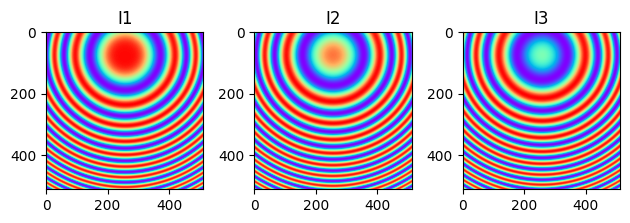

In [19]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(I1, cmap="rainbow")
axs[0].set_title("I1")
axs[1].imshow(I2, cmap="rainbow")
axs[1].set_title("I2")
axs[2].imshow(I3, cmap="rainbow")
axs[2].set_title("I3")
fig.tight_layout()

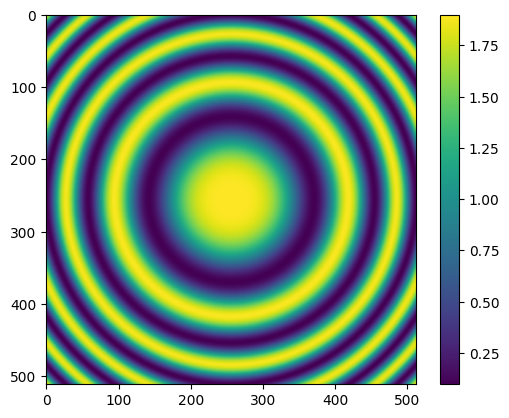

In [11]:
plt.imshow(I1)
plt.colorbar()

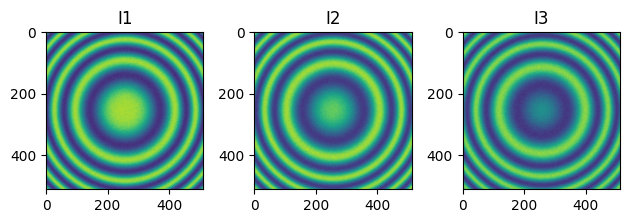

In [12]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(I1_noise)
axs[0].set_title("I1")
axs[1].imshow(I2_noise)
axs[1].set_title("I2")
axs[2].imshow(I3_noise)
axs[2].set_title("I3")
fig.tight_layout()

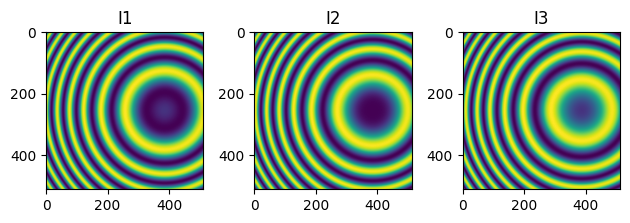

In [13]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(I1_fi2)
axs[0].set_title("I1")
axs[1].imshow(I2_fi2)
axs[1].set_title("I2")
axs[2].imshow(I3_fi2)
axs[2].set_title("I3")
fig.tight_layout()

# carre

In [14]:
def test_step_error_carre(error):
    I1_test = a1 + b1 * np.cos(fi)
    I2_test = a2 + b2 * np.cos(fi + step + (np.random.rand() - 0.5) * error)
    I3_test = a3 + b3 * np.cos(fi + 2*(step + (np.random.rand() - 0.5) * error))

    #fi_recovered = np.arctan2((I1_test - 2*I2_test + I3_test) , (I1_test - I3_test))
    fi_recovered = np.arctan2(np.sqrt(3) * (I2_test - I3_test), (I2_test + I3_test - 2*I1_test))
    fi_unwrapped = unwrap(fi_recovered)
    fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
    diff = fi - fi_unwrapped
    return rmse(diff)
    
def test_noise_carre_4(mean, deviation):
    I1_test = a1 + b1 * np.cos(fi) + np.random.normal(mean, deviation, size=(size, size))
    I2_test = a2 + b2 * np.cos(fi + np.pi/2) + np.random.normal(mean, deviation, size=(size, size))
    I3_test = a3 + b3 * np.cos(fi + 2 * np.pi/2) + np.random.normal(mean, deviation, size=(size, size))
    I4_test = a4 + b4 * np.cos(fi + 3 * np.pi/2) + np.random.normal(mean, deviation, size=(size, size))
    
    fi_recovered = np.arctan2(I4_test - I2_test, I1_test - I3_test)
    fi_unwrapped = unwrap(fi_recovered)
    fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
    diff = fi - fi_unwrapped
    return rmse(diff)

def test_noise_carre(mean, deviation):
    I1_test = a1 + b1 * np.cos(fi)# + np.random.normal(mean, deviation, size=(size, size))
    I2_test = a2 + b2 * np.cos(fi + step)# + np.random.normal(mean, deviation, size=(size, size))
    I3_test = a3 + b3 * np.cos(fi + 2*step)# + np.random.normal(mean, deviation, size=(size, size))
    
    fi_recovered = np.arctan2(np.sqrt(3) * (I2_test - I3_test), (I2_test + I3_test - 2*I1_test))
    fi_unwrapped = unwrap(fi_recovered)
    fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
    diff = fi - fi_unwrapped
    return rmse(diff)

def test_step_error_carre_5(error):
    I1_test = a1 + b1 * np.cos(fi)
    I2_test = a2 + b2 * np.cos(fi + step)
    I3_test = a3 + b3 * np.cos(fi + 2*(step + error))

    fi_recovered = np.arctan2((I1_test - 2*I2_test + I3_test) , (I1_test - I3_test))
    fi_unwrapped = unwrap(fi_recovered)
    fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
    diff = fi - fi_unwrapped
    print(rmse(diff))

In [85]:
for i in range(26):
    result = 0
    for j in range(10):
        np.random.seed(j)
        result += test_noise_carre(0, i/100)
    print('\n', i, '% rme = ', result / 10)
    


 0 % rme =  0.05770559848132588

 1 % rme =  0.05770559848132588


KeyboardInterrupt: 

In [34]:
for i in range(11):
    result = 0
    for j in range(30):
        np.random.seed(j)
        result += abs(test_step_error_carre(i/10))
    print('\n', i/10, 'rad rme = ', result / 30)


 0.0 rad rme =  0.056234627269228406


KeyboardInterrupt: 

Text(0.5, 1.0, 'fi_recovered')

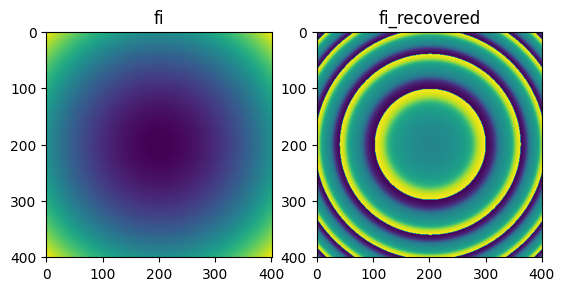

In [25]:
fi_recovered = np.arctan2((I1 - 2*I2 + I3) , (I1 - I3))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fi)
axs[0].set_title("fi")
axs[1].imshow(fi_recovered)
axs[1].set_title("fi_recovered")

[-2.93365357e-01 -3.95559216e-01 -5.23884623e-01 -6.91853104e-01
 -9.17481817e-01 -1.21483858e+00 -1.56785059e+00 -1.91574142e+00
 -2.20271638e+00 -2.41917667e+00 -2.58100348e+00 -2.70577284e+00
 -2.80629112e+00 -2.89108209e+00 -2.96585828e+00 -3.03465007e+00
 -3.10054674e+00  3.11699158e+00  3.04901392e+00  2.97583554e+00
  2.89388224e+00  2.79831354e+00  2.68223179e+00  2.53572328e+00
  2.34551926e+00  2.09845068e+00  1.79493166e+00  1.46735773e+00
  1.16773211e+00  9.26092544e-01  7.41292069e-01  5.99947020e-01
  4.89097529e-01  3.99226246e-01  3.23830978e-01  2.58490259e-01
  2.00125893e-01  1.46510168e-01  9.59471850e-02  4.70626136e-02
 -1.34321924e-03 -5.04084866e-02 -1.01309842e-01 -1.55365815e-01
 -2.14159951e-01 -2.79702566e-01 -3.54653880e-01 -4.42630689e-01
 -5.48592904e-01 -6.79188972e-01 -8.42560109e-01 -1.04622908e+00
 -1.29097573e+00 -1.56216230e+00 -1.83018403e+00 -2.06744578e+00
 -2.26282609e+00 -2.41912812e+00 -2.54432424e+00 -2.64633324e+00
 -2.73144863e+00 -2.80432

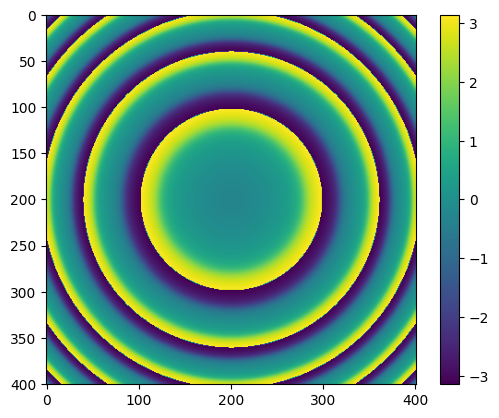

In [26]:
plt.imshow(fi_recovered)
plt.colorbar()
print(fi_recovered[0][:100])

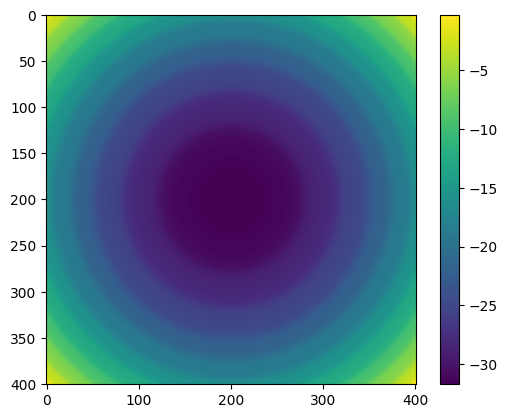

In [27]:
fi_unwrapped = unwrap(fi_recovered)
plt.imshow(fi_unwrapped)
plt.colorbar()

0.5157585946303971


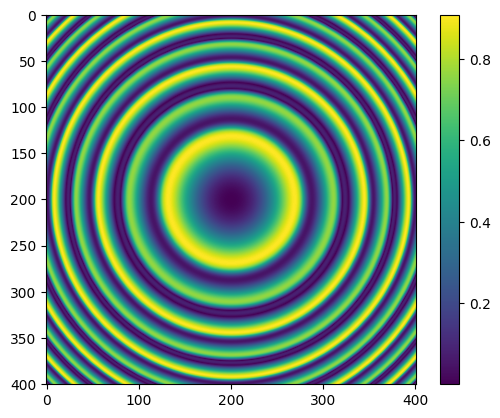

In [28]:
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff = fi - fi_unwrapped
print(rmse(diff))
plt.imshow(abs(diff))
plt.colorbar()

Text(0.5, 1.0, 'fi_unwrapped')

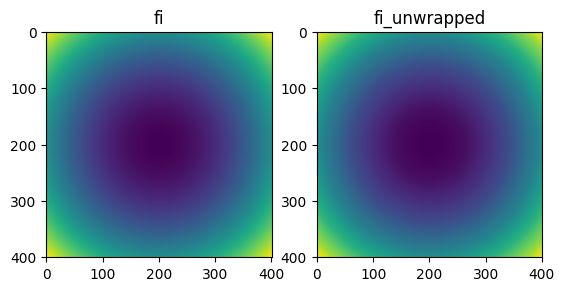

In [12]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fi)
axs[0].set_title("fi")
axs[1].imshow(fi_unwrapped)
axs[1].set_title("fi_unwrapped")

In [13]:
height_orig = (fi * 600 * 10**-9) / (4*np.pi)
height_recovered = (fi_unwrapped * 600 * 10**-9) / (4*np.pi)
fig = go.Figure(data=[go.Surface(z=height_orig)])
fig.update_layout(autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [14]:
fig = go.Figure(data=[go.Surface(z=height_recovered)])
fig.update_layout(autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

# carre_noise

Text(0.5, 1.0, 'fi_recovered')

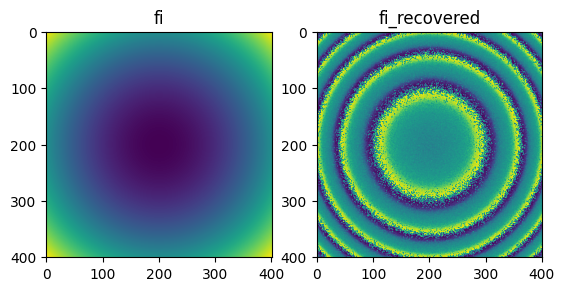

In [37]:
fi_recovered = np.arctan2((I1_noise - 2*I2_noise + I3_noise) , (I1_noise - I3_noise))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fi)
axs[0].set_title("fi")
axs[1].imshow(fi_recovered)
axs[1].set_title("fi_recovered")

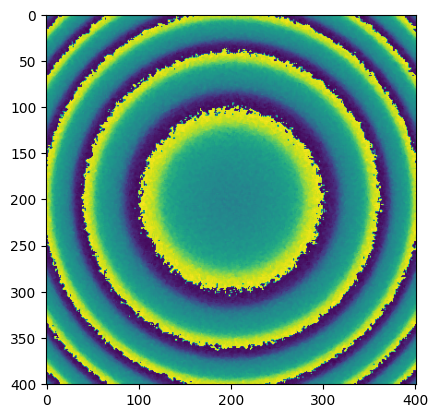

In [38]:
median_filter(fi_recovered)
plt.imshow(fi_recovered)

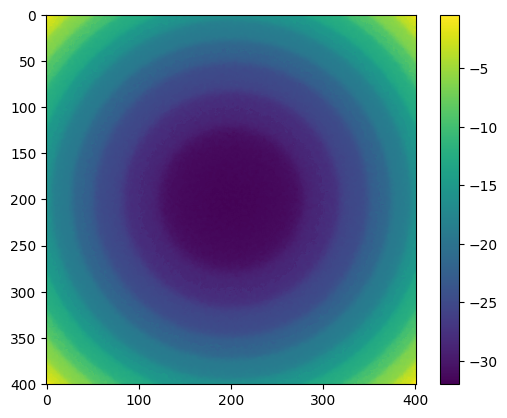

In [39]:
fi_unwrapped = unwrap(fi_recovered)
plt.imshow(fi_unwrapped)
plt.colorbar()

0.34113517389305437


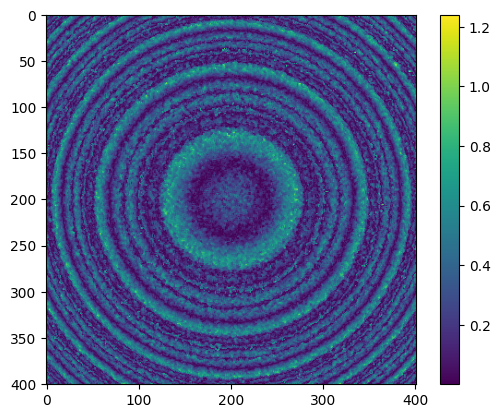

In [40]:
diff = abs(fi_unwrapped - np.min(fi_unwrapped)- fi)
print(rmse(diff))
plt.imshow(diff)
plt.colorbar()

In [ ]:
height_orig = (fi2 * 600 * 10**-9) / (4*np.pi)
height_recovered = (fi_unwrapped * 600 * 10**-9) / (4*np.pi)
fig = go.Figure(data=[go.Surface(z=height_recovered)])
fig.update_layout(autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

# carre_fi2

Text(0.5, 1.0, 'fi_recovered')

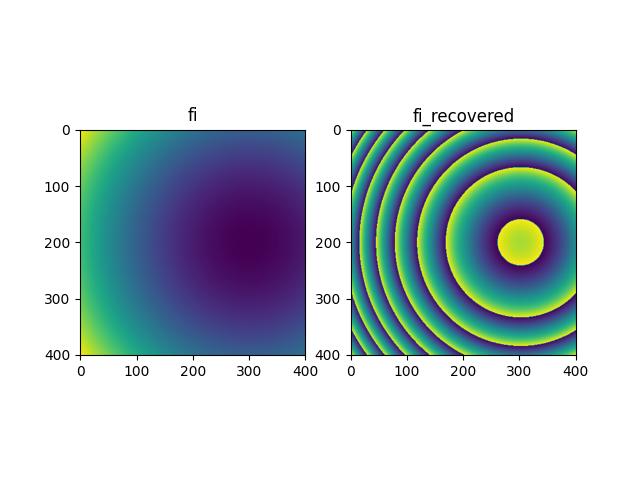

In [13]:
fi_recovered = np.arctan2((I1_fi2 - 2*I2_fi2 + I3_fi2) , (I1_fi2 - I3_fi2))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fi2)
axs[0].set_title("fi")
axs[1].imshow(fi_recovered)
axs[1].set_title("fi_recovered")

In [14]:
fi_unwrapped = unwrap(fi_recovered)
plt.imshow(fi_unwrapped)
plt.colorbar()

In [15]:
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff = fi2 - fi_unwrapped
plt.imshow(diff)
plt.colorbar()

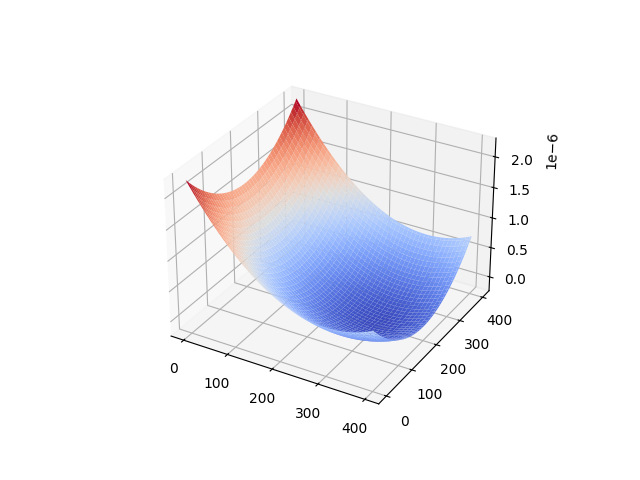

In [18]:
height_orig = (fi2 * 600 * 10**-9) / (4*np.pi)
height_recovered = (fi_unwrapped * 600 * 10**-9) / (4*np.pi)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X = np.arange(401)
Y = np.arange(401)
X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, height_orig, cmap=cm.coolwarm)
plt.show()

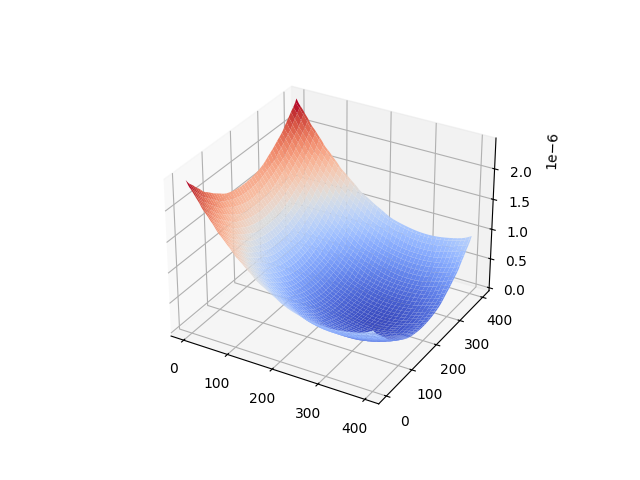

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X = np.arange(401)
Y = np.arange(401)
X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, height_recovered, cmap=cm.coolwarm)
plt.show()

# UPSA

(-1.5, 1.5)

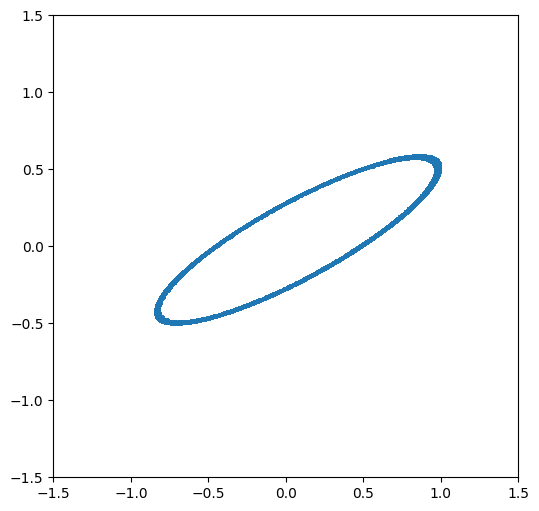

In [15]:
Z1 = np.exp(1j*(2*np.pi/3)*0)*I1 + \
np.exp(1j*(2*np.pi/3)*1)*I2 + np.exp(1j*(2*np.pi/3)*2)*I3

plt.figure(figsize=(6,6))
plt.scatter(Z1.real, Z1.imag, s=1)
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))

(-1.5, 1.5)

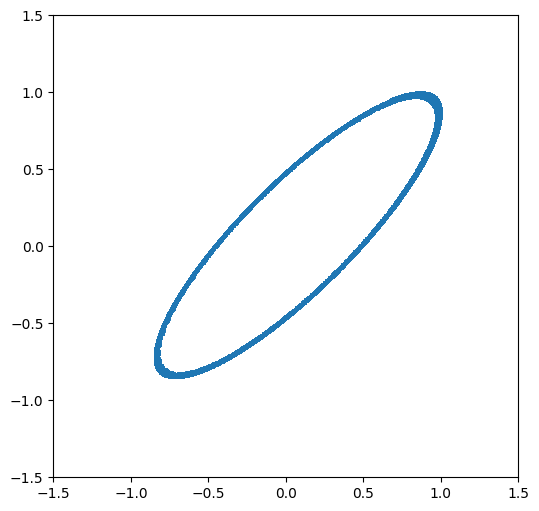

In [16]:
Z2 = Z1.real / np.max(abs(Z1.real)) + 1j*(Z1.imag / np.max(abs(Z1.imag)))
plt.figure(figsize=(6,6))
plt.scatter(Z2.real, Z2.imag, s=1)
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))

(-1.5, 1.5)

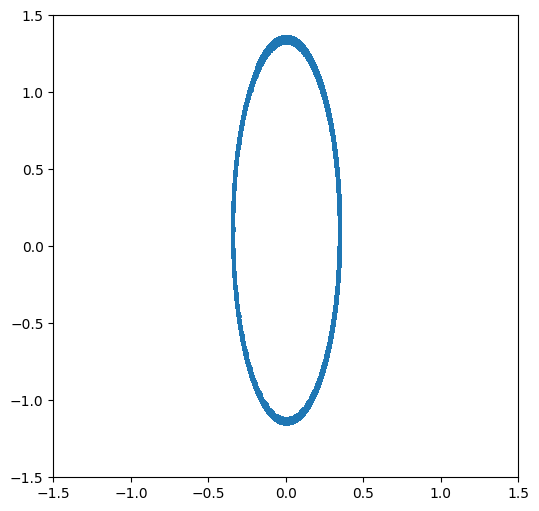

In [17]:
Z3 = np.exp(1j*np.pi/4)*Z2
plt.figure(figsize=(6,6))
plt.scatter(Z3.real, Z3.imag, s=1)
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))

(-1.5, 1.5)

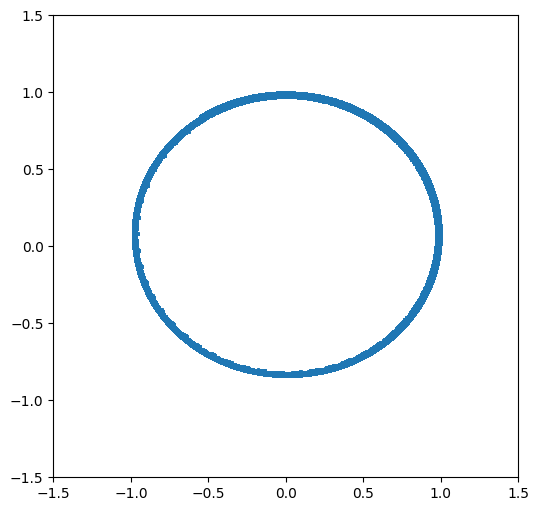

In [18]:
Z4 = Z3.real / np.max(abs(Z3.real)) + 1j*(Z3.imag / np.max(abs(Z3.imag)))
plt.figure(figsize=(6,6))
plt.scatter(Z4.real, Z4.imag, s=1)
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))

In [19]:
fi_upsa = np.arctan2(Z4.real, Z4.imag)

Text(0.5, 1.0, 'fi_recovered')

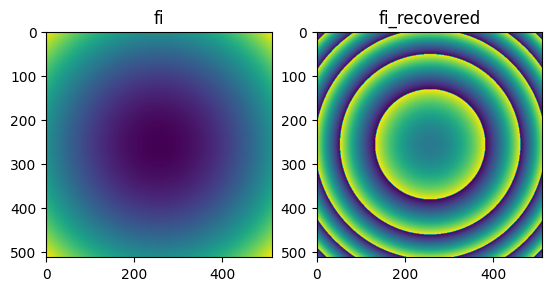

In [20]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fi)
axs[0].set_title("fi")
axs[1].imshow(fi_upsa)
axs[1].set_title("fi_recovered")

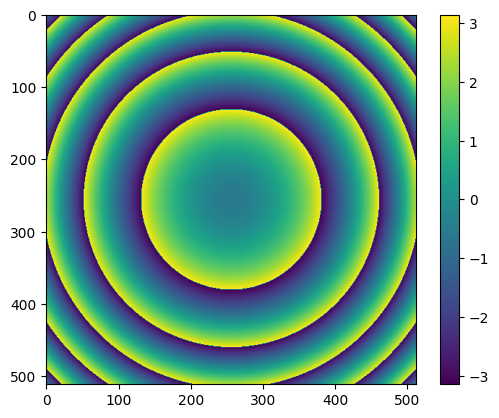

In [21]:
plt.imshow(fi_upsa)
plt.colorbar()

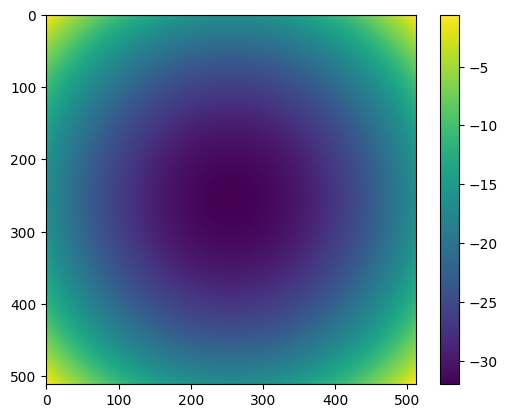

In [22]:
fi_unwrapped = unwrap(fi_upsa)
plt.imshow(fi_unwrapped)
plt.colorbar()

0.0038774458419675493


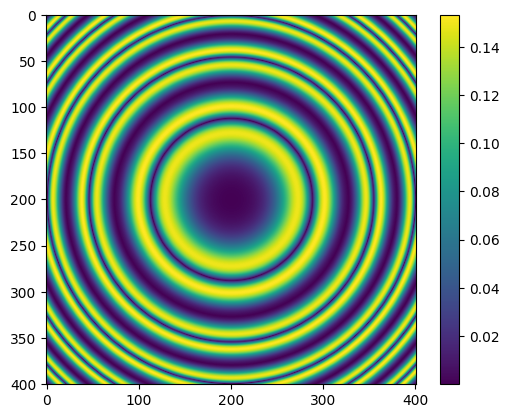

In [54]:
diff = fi - (fi_unwrapped - fi_unwrapped.min())
print(mse(diff))
plt.imshow(abs(diff))
plt.colorbar()

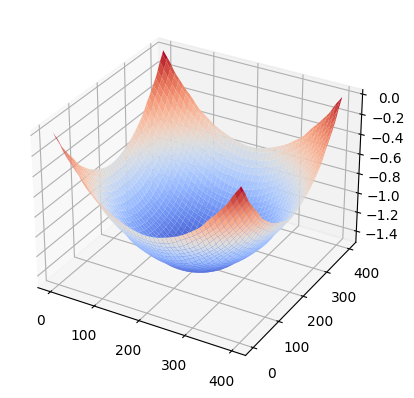

In [79]:
height_recovered = (fi_unwrapped * 600 * 10**-9) / (4*np.pi)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X = np.arange(401)
Y = np.arange(401)
X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, height_recovered, cmap=cm.coolwarm)
plt.show()

In [6]:
def test_step_error_upsa(error):
    I1_test = a1 + b1 * np.cos(fi)
    I2_test = a2 + b2 * np.cos(fi + step + (np.random.rand() - 0.5) * error)
    I3_test = a3 + b3 * np.cos(fi + 2*(step + (np.random.rand() - 0.5) * error))

    Z1 = np.exp(1j*(2*np.pi/3)*0)*I1_test + \
        np.exp(1j*(2*np.pi/3)*1)*I2_test + np.exp(1j*(2*np.pi/3)*2)*I3_test
    Z2 = Z1.real / np.max(abs(Z1.real)) + 1j*(Z1.imag / np.max(abs(Z1.imag)))
    Z3 = np.exp(1j*np.pi/4)*Z2
    Z4 = Z3.real / np.max(abs(Z3.real)) + 1j*(Z3.imag / np.max(abs(Z3.imag)))
    fi_recovered = np.arctan2(Z4.real, Z4.imag)
    
    fi_unwrapped = unwrap(fi_recovered)
    fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
    diff = fi - fi_unwrapped
    return rmse(diff)
    
def test_noise_upsa(mean, deviation):
    I1_test = I1 + np.random.normal(mean, deviation, size=(size, size))
    I2_test = I2 + np.random.normal(mean, deviation, size=(size, size))
    I3_test = I3 + np.random.normal(mean, deviation, size=(size, size))
    
    Z1 = np.exp(1j*(2*np.pi/3)*0)*I1_test + \
        np.exp(1j*(2*np.pi/3)*1)*I2_test + np.exp(1j*(2*np.pi/3)*2)*I3_test
    Z2 = Z1.real / np.max(abs(Z1.real)) + 1j*(Z1.imag / np.max(abs(Z1.imag)))
    Z3 = np.exp(1j*np.pi/4)*Z2
    Z4 = Z3.real / np.max(abs(Z3.real)) + 1j*(Z3.imag / np.max(abs(Z3.imag)))
    fi_recovered = np.arctan2(Z4.real, Z4.imag)
    
    fi_unwrapped = unwrap(fi_recovered)
    fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
    diff = fi - fi_unwrapped
    return rmse(diff)

In [45]:
for i in range(26):
    result = 0
    for j in range(10):
        np.random.seed(j)
        result += test_noise_upsa(0, i/100)
    print('\n', i, '% rme = ', result / 10)


 0 % rme =  0.052534999419425396

 1 % rme =  0.059938658075047266

 2 % rme =  0.07803801918684664

 3 % rme =  0.10184592665043543

 4 % rme =  0.1282184142967656

 5 % rme =  0.15572541903064316

 6 % rme =  0.1839484258632446

 7 % rme =  0.21241654414962494

 8 % rme =  0.24103938095667687

 9 % rme =  0.27004217353368265

 10 % rme =  0.2993860261704962

 11 % rme =  0.3285532688297922

 12 % rme =  0.3571511505224882

 13 % rme =  0.38571198156626874

 14 % rme =  0.41553889572444824

 15 % rme =  0.4456212419177552

 16 % rme =  0.47573585227270543

 17 % rme =  0.5062400747092541

 18 % rme =  0.5374886794366457

 19 % rme =  0.5719876906323891

 20 % rme =  0.609546040751895

 21 % rme =  0.6474224074490809

 22 % rme =  0.6862642231449436

 23 % rme =  0.7392652913789334

 24 % rme =  0.8293988542175749

 25 % rme =  0.8984863527224258


In [7]:
for i in range(11):
    result = 0
    for j in range(10):
        np.random.seed(j)
        result += test_step_error_upsa(i/10)
    print('\n', i/10, 'rad rme = ', result / 10)


 0.0 rad rme =  0.052534999419425396

 0.1 rad rme =  0.052951918117948915

 0.2 rad rme =  0.05350536234674543

 0.3 rad rme =  0.05420030691835008

 0.4 rad rme =  0.055045245359738836

 0.5 rad rme =  0.05605183610093607

 0.6 rad rme =  0.05723507277054337

 0.7 rad rme =  0.05861352088712235

 0.8 rad rme =  0.06021053550732397

 0.9 rad rme =  0.06205559101809066

 1.0 rad rme =  0.06415778961650623


# UPSA_noise

(-1.5, 1.5)

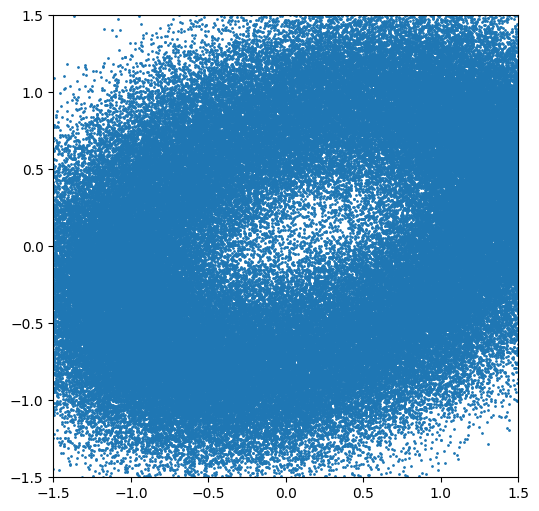

In [64]:
Z1 = np.exp(1j*(2*np.pi/3)*0)*I1_noise + \
np.exp(1j*(2*np.pi/3)*1)*I2_noise + np.exp(1j*(2*np.pi/3)*2)*I3_noise

plt.figure(figsize=(6,6))
plt.scatter(Z1.real, Z1.imag, s=1)
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))

(-1.5, 1.5)

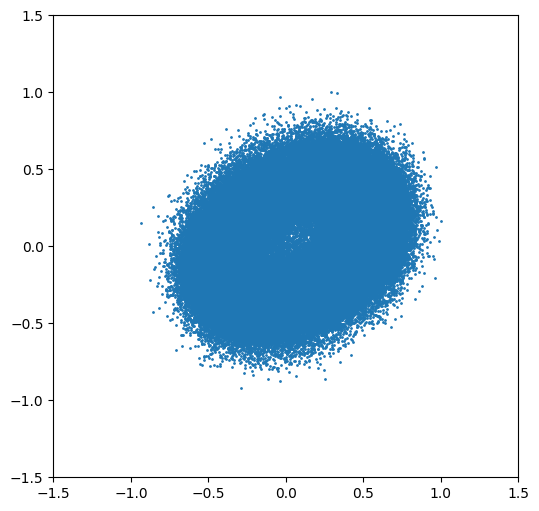

In [65]:
Z2 = Z1.real / np.max(abs(Z1.real)) + 1j*(Z1.imag / np.max(abs(Z1.imag)))
plt.figure(figsize=(6,6))
plt.scatter(Z2.real, Z2.imag, s=1)
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))

(-1.5, 1.5)

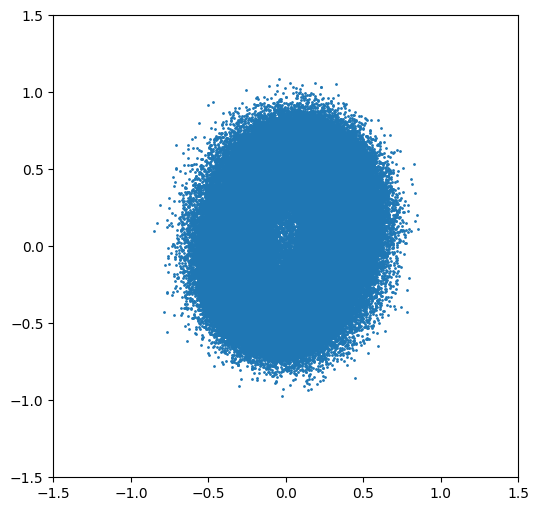

In [66]:
Z3 = np.exp(1j*np.pi/4)*Z2
plt.figure(figsize=(6,6))
plt.scatter(Z3.real, Z3.imag, s=1)
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))

(-1.5, 1.5)

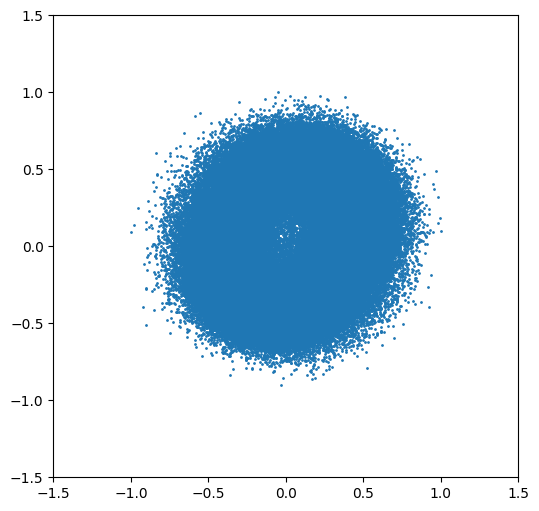

In [67]:
Z4 = Z3.real / np.max(abs(Z3.real)) + 1j*(Z3.imag / np.max(abs(Z3.imag)))
plt.figure(figsize=(6,6))
plt.scatter(Z4.real, Z4.imag, s=1)
plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))

In [68]:
fi_upsa = np.arctan2(Z4.real, Z4.imag)

Text(0.5, 1.0, 'fi_recovered')

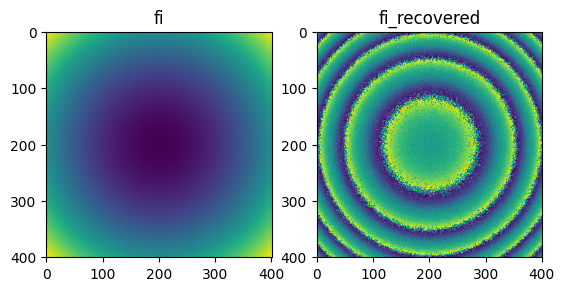

In [69]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(fi)
axs[0].set_title("fi")
axs[1].imshow(fi_upsa)
axs[1].set_title("fi_recovered")

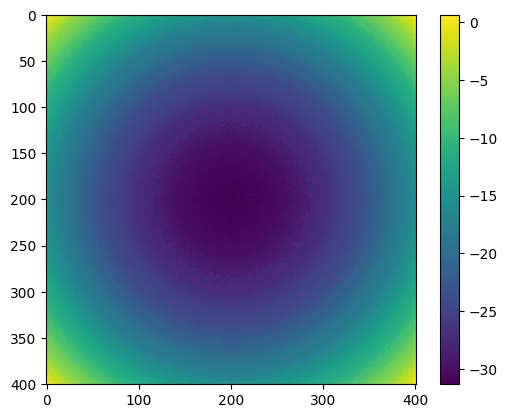

In [78]:
median_filter(fi_upsa)
fi_unwrapped = unwrap(fi_upsa)
plt.imshow(fi_unwrapped)
plt.colorbar()

0.25250929758489765


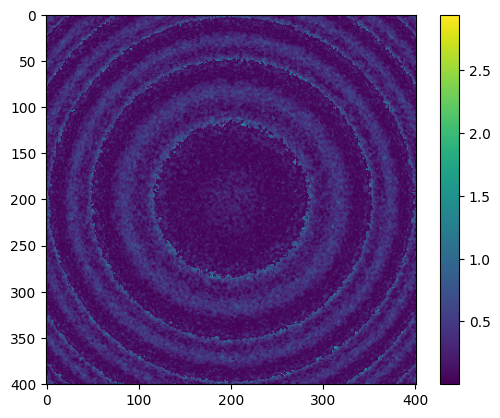

In [79]:
diff = abs(fi_unwrapped - np.min(fi_unwrapped)- fi)
print(mse(diff))
plt.imshow(diff)
plt.colorbar()

# trajectory

In [5]:
I1_norm = (I1-np.min(I1))/(np.max(I1)-np.min(I1))
I2_norm = (I2-np.min(I2))/(np.max(I2)-np.min(I2))
I3_norm = (I3-np.min(I3))/(np.max(I3)-np.min(I3))
ellipse = pd.DataFrame({'I1':I1_norm.flatten(), 'I2':I2_norm.flatten(), 'I3':I3_norm.flatten()})
fig = px.scatter_3d(ellipse, x='I1', y='I2', z='I3')
fig.update_layout(autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_traces(marker_size=1)
fig.show()
# углы между образующими и плоскотсью должны быть равны

In [51]:
I1_center = np.mean(I1)
I2_center = np.mean(I2)
I3_center = np.max(I3)
I1_top = I1_center
I2_top = I2_center
I3_top = I3_center * 3
trace1 = go.Scatter3d(x=I1.flatten(), y=I2.flatten(), z=I3.flatten(), mode='markers', marker=dict(size=1))
trace2 = go.Scatter3d(x=[I1_center, I1_top], y=[I2_center, I2_top], z=[I3_center, I3_top], mode='lines',  marker=dict(size=4))
drawings = [trace1, trace2]

#x_generators = np.empty([I1.flatten().size, 2])
#y_generators = np.empty([I2.flatten().size, 2])
#z_generators = np.empty([I3.flatten().size, 2])
for i in range(0, I1.flatten().size, 2000):
    drawings.append(go.Scatter3d(x=(I1.flatten()[i], I1_top),
                                 y=(I2.flatten()[i], I2_top),
                                 z=(I3.flatten()[i], I3_top), mode='lines',  marker=dict(size=4)))
    #x_generators[i] = (I1.flatten()[i], I1_top)
    #y_generators[i] = (I2.flatten()[i], I2_top)
    #z_generators[i] = (I3.flatten()[i], I3_top)
    


#trace3 = go.Scatter3d(x=x_generators, y=y_generators, z=z_generators, mode='lines',  marker=dict(size=4))
fig = go.Figure(drawings)
fig.show()

In [52]:
I1_norm = (I1-np.min(I1))/(np.max(I1)-np.min(I1))
I2_norm = (I2-np.min(I2))/(np.max(I2)-np.min(I2))
I3_norm = (I3-np.min(I3))/(np.max(I3)-np.min(I3))
I1_flatten = I1_norm.flatten()
I2_flatten = I2_norm.flatten()
I3_flatten = I3_norm.flatten()
    

In [53]:
S = np.array([np.mean(I1_flatten)*1.1, np.mean(I2_flatten), 3*np.mean(I3_flatten)]) # Вершина задается произвольно
Alias = np.array([1,1,3]) # Смещение вниз по одной координате (начальное условие)

number_of_points = I1_flatten.size
P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]

R = S - P

Q = np.empty([number_of_points-1, 3])
for i in range(number_of_points-1):
    Q[i] = R[i]/np.linalg.norm(R[i])-R[i+1]/np.linalg.norm(R[i+1])

QTQ = np.matmul(np.transpose(Q), Q)

print("P = \n", P, "\n")

print("S = \n", S, "\n")

print("Alias = \n", Alias, "\n")

print("Q = \n", Q, "\n")

print("QTQ = \n", QTQ, " \n")

K = np.matmul(np.matmul(np.transpose(Q), Q), S)
print("K = \n", K)

P = 
 [[0.95869208 0.48215318 0.        ]
 [0.95304799 0.5573833  0.00587943]
 [0.93596489 0.63045187 0.02323975]
 ...
 [0.86939234 0.76427376 0.09048838]
 [0.90768599 0.70031195 0.05183895]
 [0.93585074 0.63081154 0.02335539]] 

S = 
 [0.53731441 0.46651057 1.50333023] 

Alias = 
 [1 1 3] 

Q = 
 [[-0.00282748  0.04835493  0.00092943]
 [-0.00845457  0.04797274  0.00179909]
 [-0.01413936  0.04738644  0.00271775]
 ...
 [ 0.02626525 -0.04556621 -0.00489275]
 [ 0.02014805 -0.04676882 -0.003754  ]
 [ 0.01425516 -0.04762211 -0.00273889]] 

QTQ = 
 [[180.56252688  -3.10267232 -49.48261872]
 [ -3.10267232 156.78909213   5.32283102]
 [-49.48261872   5.32283102  14.24934315]]  

K = 
 [21.18270076 79.47863165 -2.68309859]


In [54]:
QAlias = copy.deepcopy(Q)
for row in QAlias:
    row[2] *= 3 
O = np.linalg.lstsq(QAlias, np.matmul(Q, S))
O=O[0]
print(O)

[0.53731441 0.46651057 0.50111008]


C:\Users\Fedor\AppData\Local\Temp\ipykernel_15948\2491050092.py:4: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [34]:
#A = S - P
#b = np.matmul((S - P), S)
#O = np.polynomial.polynomial.polyfit(x=A, y=b, deg=2)
#print(O)

In [57]:
trace1 = go.Scatter3d(x=I1.flatten(), y=I2.flatten(), z=I3.flatten(), mode='markers', marker=dict(size=1))
trace2 = go.Scatter3d(x=[O[0], S[0]], y=[O[1], S[1]], z=[O[2], S[2]], mode='lines',  marker=dict(size=4))
drawings = [trace1, trace2]

for i in range(0, I1.flatten().size, 2000):
    drawings.append(go.Scatter3d(x=(P[i][0], S[0]),
                                 y=(P[i][1], S[1]),
                                 z=(P[i][2], S[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show()

# Trajectory2

In [150]:
aaa = np.array([3., 4.])
bbb = np.array([4., 3.])

ab = np.matmul(aaa, bbb)
print(np.cos(ab/25))

aaa = normalize_matrix([aaa])[0]
bbb = normalize_matrix([bbb])[0]
print(aaa)
print(bbb)  # Неправильная нормировка вектора, Уравнения работают только с нормированными

ab = np.matmul(aaa, bbb)
print(np.cos(ab))

0.5735199860724567
[0.6 0.8]
[0.8 0.6]
0.5735199860724567


In [151]:
I1_flatten = I1.flatten()
I2_flatten = I2.flatten()
I3_flatten = I3.flatten()


In [161]:
S = np.array([np.mean(I1_flatten), np.mean(I2_flatten), 6*np.mean(I3_flatten)]) # Вершина задается произвольно
#S = normalize_matrix([S])[0]
Alias = np.array([1,1,3]) # Смещение вниз по одной координате (начальное условие)

number_of_points = I1_flatten.size
P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]    
P_norm = normalize_matrix(P)
S_norm = normalize_matrix([S])[0]
R = S_norm - P_norm

Q = np.empty([number_of_points-1, 3])
for i in range(number_of_points-1):
    Q[i] = R[i]-R[i+1]

QTQ = np.matmul(np.transpose(Q), Q)



print("P = \n", P, "\n")

print("S = \n", S, "\n")

print("Alias = \n", Alias, "\n")

print("Q = \n", Q, "\n")

print("QTQ = \n", QTQ, " \n")

print("S_norm = \n", S_norm, "\n")

K = np.matmul(np.matmul(np.transpose(Q), Q), S)
print("K = \n", K)

P = 
 [[1.82549993 0.91274997 0.09607894]
 [1.81532072 1.04008123 0.10546921]
 [1.78451104 1.16375397 0.13319601]
 ...
 [1.66444626 1.39025517 0.24060133]
 [1.73350955 1.28199615 0.17887288]
 [1.78430517 1.16436274 0.13338072]] 

S = 
 [0.97744177 0.88627396 5.37852367] 

Alias = 
 [1 1 3] 

Q = 
 [[-0.0268629   0.04978196  0.00332452]
 [-0.03058418  0.04868351  0.01205084]
 [-0.03435649  0.04691921  0.02003915]
 ...
 [ 0.0423884  -0.04115011 -0.0343006 ]
 [ 0.03845553 -0.04458299 -0.02758791]
 [ 0.03456044 -0.04714141 -0.02019912]] 

QTQ = 
 [[ 156.21674765  -39.19249009 -115.81619899]
 [ -39.19249009   84.01576851  -26.0339833 ]
 [-115.81619899  -26.0339833   149.16464861]]  

S_norm = 
 [0.1764974  0.16003516 0.9712041 ] 

K = 
 [-504.96267625 -103.87178411  666.00876049]


In [ ]:
QAlias = copy.deepcopy(Q)
for row in QAlias:
    row = np.matmul(row, Alias) 
O = np.linalg.lstsq(QAlias, np.matmul(Q, S_norm))
O=O[0]
print(O)


In [178]:
trace1 = go.Scatter3d(x=np.transpose(P)[0], y=np.transpose(P_norm)[1], z=np.transpose(P_norm)[2], mode='markers', marker=dict(size=1))
trace2 = go.Scatter3d(x=[O[0], S_norm[0]], y=[O[1], S_norm[1]], z=[O[2], S_norm[2]], mode='lines',  marker=dict(size=4))
drawings = [trace1, trace2]

for i in range(0, I1.flatten().size, 2000):
    drawings.append(go.Scatter3d(x=(P_norm[i][0], S_norm[0]),
                                 y=(P_norm[i][1], S_norm[1]),
                                 z=(P_norm[i][2], S_norm[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show()

# Treajectory3

In [32]:
I1_flatten = I1.flatten()
I2_flatten = I2.flatten()
I3_flatten = I3.flatten()

S = np.array([np.mean(I1_flatten), np.mean(I2_flatten), 6*np.mean(I3_flatten)])

number_of_points = I1_flatten.size
P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]   

R = S - P

PT = np.transpose(P)
O = np.array([np.mean(PT[0]), np.mean(PT[1]), np.mean(PT[2])]) # Неправильно

print("P = \n", P, "\n")
print("O = \n", O, "\n")
print("S = \n", S, "\n")



P = 
 [[1.82549993 0.50441446 0.48039472]
 [1.81532072 0.61960806 0.38153845]
 [1.78451104 0.74137489 0.29483133]
 ...
 [1.66444626 0.99445618 0.16438289]
 [1.73350955 0.86797434 0.22152681]
 [1.78430517 0.74199988 0.29442866]] 

O = 
 [0.97744177 0.89754478 0.93397897] 

S = 
 [0.97744177 0.89754478 5.60387381] 



In [33]:
P_vec_norm = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P_vec_norm[i] = S - P[i]
P_vec_norm = normalize_matrix(P_vec_norm)
O_new = np.array([0., 0., 0.])
for i in range(number_of_points):
    O_new[0] += P_vec_norm[i][0]
    O_new[1] += P_vec_norm[i][1]
    O_new[2] += P_vec_norm[i][2]
O_new[0] /= number_of_points / 5
O_new[1] /= number_of_points / 5
O_new[2] /= number_of_points / 5  
O_new = S - O_new
print(O_new)

#S[0] = O_new[0]
#S[1] = O_new[1]

[0.93990597 0.86094359 0.68900707]


In [34]:
Q = np.empty([number_of_points-1, 3])
for i in range(number_of_points-1):
    Q[i] = R[i]/np.linalg.norm(R[i])-R[i+1]/np.linalg.norm(R[i+1])

QTQ = np.matmul(np.transpose(Q), Q)
E = np.matmul(QTQ, O_new) - np.matmul(QTQ, S)
print(E)
print(np.sqrt(E[0]*E[0] + E[1]*E[1] + E[2]*E[2]))

[ 0.48676087 -1.12848692 -0.86196112]
1.5011315224702095


In [35]:
trace1 = go.Scatter3d(x=PT[0], y=PT[1], z=PT[2], mode='markers', marker=dict(size=1))
trace2 = go.Scatter3d(x=[O_new[0], S[0]], y=[O_new[1], S[1]], z=[O_new[2], S[2]], mode='lines',  marker=dict(size=4))
drawings = [trace1, trace2]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P[i][0], S[0]),
                                 y=(P[i][1], S[1]),
                                 z=(P[i][2], S[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show()

In [36]:
P_proj = projection(P, O_new, S, number_of_points)
P_projT = np.transpose(P_proj)

trace1 = go.Scatter3d(x=PT[0], y=PT[1], z=PT[2], mode='markers', marker=dict(size=1))
trace2 = go.Scatter3d(x=P_projT[0], y=P_projT[1], z=P_projT[2], mode='markers', marker=dict(size=1))
trace3 = go.Scatter3d(x=[O_new[0], S[0]], y=[O_new[1], S[1]], z=[O_new[2], S[2]], mode='lines',  marker=dict(size=4))
drawings = [trace1, trace2, trace3]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S[0]),
                                 y=(P_proj[i][1], S[1]),
                                 z=(P_proj[i][2], S[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show()

0.005795144955689967


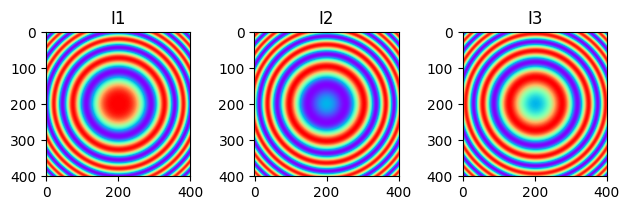

In [40]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(I1, cmap="rainbow")
axs[0].set_title("I1")
axs[1].imshow(I2, cmap="rainbow")
axs[1].set_title("I2")
axs[2].imshow(I3, cmap="rainbow")
axs[2].set_title("I3")
fig.tight_layout()
print(K_form(O_new, P_proj, number_of_points))

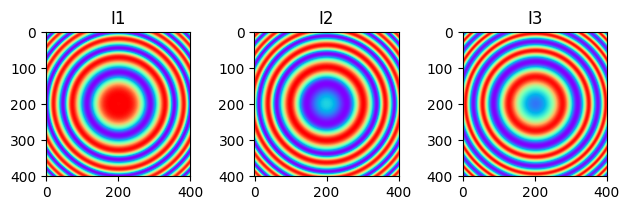

In [38]:
I_transformed1 = np.transpose(P_proj)[0].reshape((401, 401))
I_transformed2 = np.transpose(P_proj)[1].reshape((401, 401))
I_transformed3 = np.transpose(P_proj)[2].reshape((401, 401))

fig, axs = plt.subplots(1, 3)
axs[0].imshow(I_transformed1, cmap="rainbow")
axs[0].set_title("I1")
axs[1].imshow(I_transformed2, cmap="rainbow")
axs[1].set_title("I2")
axs[2].imshow(I_transformed3, cmap="rainbow")
axs[2].set_title("I3")
fig.tight_layout()

# Trajectory full

In [39]:
I1_flatten = I1.flatten()
I2_flatten = I2.flatten()
I3_flatten = I3.flatten()

S = np.array([np.mean(I1_flatten), np.mean(I2_flatten), 6*np.mean(I3_flatten)])

number_of_points = I1_flatten.size
P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]   

R = S - P

P_vec_norm = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P_vec_norm[i] = S - P[i]
P_vec_norm = normalize_matrix(P_vec_norm)
O = np.array([0., 0., 0.])
for i in range(number_of_points):
    O[0] += P_vec_norm[i][0]
    O[1] += P_vec_norm[i][1]
    O[2] += P_vec_norm[i][2]
O[0] /= number_of_points / 5
O[1] /= number_of_points / 5
O[2] /= number_of_points / 5  
O = S - O

P_proj = projection(P, O, S, number_of_points)

I_transformed1 = np.transpose(P_proj)[0].reshape((401, 401))
I_transformed2 = np.transpose(P_proj)[1].reshape((401, 401))
I_transformed3 = np.transpose(P_proj)[2].reshape((401, 401))

fi_recovered = np.arctan2(-np.sqrt(3) * (I2 - I3), (I2 + I3 - 2*I1))
fi_unwrapped = unwrap(fi_recovered)
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff = fi - fi_unwrapped
print("orig", rmse(diff))

fi_recovered = np.arctan2(-np.sqrt(3) * (I_transformed2 - I_transformed3), (I_transformed2 + I_transformed3 - 2*I_transformed1))
fi_unwrapped = unwrap(fi_recovered)
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff = fi - fi_unwrapped
print("transformed", rmse(diff))

orig 16.909765831048922
transformed 16.997439556020986


# Trajectory search

In [29]:
I1_flatten = I1.flatten()
I2_flatten = I2.flatten()
I3_flatten = I3.flatten()

S = np.array([np.mean(I1_flatten), np.mean(I2_flatten), 6*np.mean(I3_flatten)])

number_of_points = I1_flatten.size
P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]   

R = S - P

P_vec_norm = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P_vec_norm[i] = S - P[i]
P_vec_norm = normalize_matrix(P_vec_norm)
O = np.array([0., 0., 0.])
for i in range(number_of_points):
    O[0] += P_vec_norm[i][0]
    O[1] += P_vec_norm[i][1]
    O[2] += P_vec_norm[i][2]
O[0] /= number_of_points / 5
O[1] /= number_of_points / 5
O[2] /= number_of_points / 5  
O = S - O

# ---------  Параметры Изначальной Плоскости --------
# Нормаль на плоскость
directional_vector = np.array([(S[0] - O[0]), (S[1] - O[1]), (S[2] - O[2])]) 
    
# Компоненты уравнения плоскости перпендикулярной оси
plane1_x = directional_vector[0]
plane1_y = directional_vector[1]
plane1_z = directional_vector[2]
plane1_D = -(directional_vector[0] * O[0]) - (directional_vector[1] * O[1]) - (directional_vector[2] * O[2])
print(plane1_x, plane1_y, plane1_z, plane1_D)
# ---------------------------------------------------

P_proj = projection(P, O, S, number_of_points)
print(K_form(P, number_of_points))
form_initial = K_form(P_proj, number_of_points)
print(form_initial)
 

0.037535801154662596 0.03660119668831352 4.914866739844394 -3.45316960097853
0.002556746603243143
0.02847420140013289


In [84]:
# Компоненты уравнения плоскости перпендикулярной оси
plane1_x = directional_vector[0]
plane1_y = directional_vector[1]
plane1_z = directional_vector[2]
plane1_D = -(directional_vector[0] * O[0]) - (directional_vector[1] * O[1]) - (directional_vector[2] * O[2])

PT = np.transpose(P)

#Сдвигаем плоскость, чтобы O стала началом координат
plane1_D_origin = plane1_D + plane1_x*O[0] + plane1_y*O[1] + plane1_z*O[2]
A = -np.pi / 6
B = np.pi / 6
plane1_x_variant = plane1_x
plane1_y_variant = plane1_y * np.cos(A) - plane1_z * np.sin(A)
plane1_z_variant = plane1_y * np.sin(A) + plane1_z * np.cos(A)

plane1_x_variant2 = plane1_x_variant * np.cos(B) + plane1_z_variant * np.sin(B)
plane1_y_variant2 = plane1_y_variant
plane1_z_variant2 = -plane1_x_variant * np.sin(B) + plane1_z_variant * np.cos(B)
plane1_D = plane1_D_origin - plane1_x_variant2 * O[0] - plane1_y_variant2 * O[1] - plane1_z_variant2 * O[2]

P_proj2 = projection_params(P, O, S, number_of_points, plane1_x_variant2, plane1_y_variant2, plane1_z_variant2, plane1_D)

P_projT2 = np.transpose(P_proj2)

trace1 = go.Scatter3d(x=PT[0], y=PT[1], z=PT[2], mode='markers', marker=dict(size=1))
trace2 = go.Scatter3d(x=P_projT2[0], y=P_projT2[1], z=P_projT2[2], mode='markers', marker=dict(size=1))
trace3 = go.Scatter3d(x=[O[0], S[0]], y=[O[1], S[1]], z=[O[2], S[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj2[i][0], S[0]),
                                 y=(P_proj2[i][1], S[1]),
                                 z=(P_proj2[i][2], S[2]), mode='lines',  marker=dict(size=4)))

print(K_form(P_proj2, number_of_points))
fig = go.Figure(drawings)
fig.show()

0.009325151506154166


In [87]:
# Компоненты уравнения плоскости перпендикулярной оси
plane1_x = directional_vector[0]
plane1_y = directional_vector[1]
plane1_z = directional_vector[2]
plane1_D = -(directional_vector[0] * O[0]) - (directional_vector[1] * O[1]) - (directional_vector[2] * O[2])

PT = np.transpose(P)

results = np.empty([70, 3])
for i in range (35):
    results[i][0] = (i+1)*10
    results[i][1] = (i+1)*10
    results[i+35][0] = (i+1)*10
    results[i+35][1] = (35 - i+1)*10
for i in range (70):
    plane1_D_origin = plane1_D + plane1_x*O[0] + plane1_y*O[1] + plane1_z*O[2]
    A = 2*np.pi / 360 * results[i][0]
    B = 2*np.pi / 360 * results[i][1]
    plane1_x_variant = plane1_x
    plane1_y_variant = plane1_y * np.cos(A) - plane1_z * np.sin(A)
    plane1_z_variant = plane1_y * np.sin(A) + plane1_z * np.cos(A)

    plane1_x_variant2 = plane1_x_variant * np.cos(B) + plane1_z_variant * np.sin(B)
    plane1_y_variant2 = plane1_y_variant
    plane1_z_variant2 = -plane1_x_variant * np.sin(B) + plane1_z_variant * np.cos(B)
    plane1_D = plane1_D_origin - plane1_x_variant2 * O[0] - plane1_y_variant2 * O[1] - plane1_z_variant2 * O[2]

    P_proj2 = projection_params(P, O, S, number_of_points, plane1_x_variant2, plane1_y_variant2, plane1_z_variant2, plane1_D)
    form = K_form(P_proj2, number_of_points)
    results[i][2] = form
    print(i)
print(results)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
[[1.00000000e+01 1.00000000e+01 3.26310610e-02]
 [2.00000000e+01 2.00000000e+01 5.05462062e-02]
 [3.00000000e+01 3.00000000e+01 1.04150451e-01]
 [4.00000000e+01 4.00000000e+01 3.04587753e-01]
 [5.00000000e+01 5.00000000e+01 1.74018331e+00]
 [6.00000000e+01 6.00000000e+01 1.30584869e+02]
 [7.00000000e+01 7.00000000e+01 6.61875234e+06]
 [8.00000000e+01 8.00000000e+01 2.59770201e+06]
 [9.00000000e+01 9.00000000e+01 6.58862547e+07]
 [1.00000000e+02 1.00000000e+02 2.24544929e+08]
 [1.10000000e+02 1.10000000e+02 1.49685483e+07]
 [1.20000000e+02 1.20000000e+02 1.75688325e+02]
 [1.30000000e+02 1.30000000e+02 5.27074931e+00]
 [1.40000000e+02 1.40000000e+02 3.72235771e-01]
 [1.50000000e+02 1.50000000e+02 2.67629194e-01]
 [1.60000000e+02 1.60000000e+02 4.10831200e-01]
 [1.70000000e+02 1.70000000e+02 

In [88]:
resultsT = np.transpose(results)
for i in range(70):
    if resultsT[2][i] > 1: resultsT[2][i] = 1
trace1 = go.Scatter3d(x=resultsT[0], y=resultsT[1], z=resultsT[2], mode='markers', marker=dict(size=1))
fig = go.Figure([trace1])
fig.show()

In [ ]:
# Компоненты уравнения плоскости перпендикулярной оси
plane1_x = directional_vector[0]
plane1_y = directional_vector[1]
plane1_z = directional_vector[2]
plane1_D = -(directional_vector[0] * O[0]) - (directional_vector[1] * O[1]) - (directional_vector[2] * O[2])

PT = np.transpose(P)

iterations_x = 0
iterations_y = 0

step = np.pi / 6
direction = 1
form_prev = form_initial
reverse_count_current = 0
reverse_count = 0
plane1_x_variant_prev = plane1_x
plane1_y_variant_prev = plane1_y
plane1_z_variant_prev = plane1_z
while True:
    plane1_D_origin = plane1_D + plane1_x_variant_prev*O[0] + plane1_y_variant_prev*O[1] + plane1_z_variant_prev*O[2]
    plane1_x_variant = plane1_x_variant_prev
    plane1_y_variant = plane1_y_variant_prev * np.cos(step*direction) - plane1_z_variant_prev * np.sin(step*direction)
    plane1_z_variant = plane1_y_variant_prev * np.sin(step*direction) + plane1_z_variant_prev * np.cos(step*direction)
    plane1_D = plane1_D_origin - plane1_x_variant * O[0] - plane1_y_variant * O[1] - plane1_z_variant * O[2]
    
    P_proj2 = projection_params(P, O, S, number_of_points, plane1_x_variant, plane1_y_variant, plane1_z_variant, plane1_D)
    form_transformed = K_form(P_proj2, number_of_points)
    if form_transformed > form_prev:
        direction = -direction
        reverse_count += 1
        reverse_count_current += 1
    else:
        reverse_count_current =0
    if reverse_count_current >= 2:
        step = step / 5
    iterations_x += 1
    form_prev = form_transformed
    plane1_x_variant_prev = plane1_x_variant
    plane1_y_variant_prev = plane1_y_variant
    plane1_z_variant_prev = plane1_z_variant
    if reverse_count >= 4:
        break
    print(iterations_x)
    print(form_prev)

step = np.pi / 6
direction = 1
reverse_count = 0
reverse_count_current = 0
while True:
    plane1_D_origin = plane1_D + plane1_x_variant_prev*O[0] + plane1_y_variant_prev*O[1] + plane1_z_variant_prev*O[2]
    plane1_x_variant = plane1_x_variant_prev * np.cos(step*direction) + plane1_z_variant_prev * np.sin(step*direction)
    plane1_y_variant = plane1_y_variant_prev
    plane1_z_variant = -plane1_x_variant_prev * np.sin(step*direction) + plane1_z_variant_prev * np.cos(step*direction)
    plane1_D = plane1_D_origin - plane1_x_variant * O[0] - plane1_y_variant * O[1] - plane1_z_variant * O[2]
    
    P_proj2 = projection_params(P, O, S, number_of_points, plane1_x_variant, plane1_y_variant, plane1_z_variant, plane1_D)
    form_transformed = K_form(P_proj2, number_of_points)
    if form_transformed > form_prev:
        direction = -direction
        reverse_count += 1
        reverse_count_current += 1
    else:
        reverse_count_current =0
    if reverse_count_current >= 2:
        step = step / 5
    iterations_y += 1
    form_prev = form_transformed
    plane1_x_variant_prev = plane1_x_variant
    plane1_y_variant_prev = plane1_y_variant
    plane1_z_variant_prev = plane1_z_variant
    if reverse_count >= 4:
        break
    print(iterations_y)
    print(form_prev)
    
print(plane1_x_variant, plane1_y_variant)
print(form_prev)

P_projT2 = np.transpose(P_proj2)

trace1 = go.Scatter3d(x=PT[0], y=PT[1], z=PT[2], mode='markers', marker=dict(size=1))
trace2 = go.Scatter3d(x=P_projT2[0], y=P_projT2[1], z=P_projT2[2], mode='markers', marker=dict(size=1))
trace3 = go.Scatter3d(x=[O[0], S[0]], y=[O[1], S[1]], z=[O[2], S[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj2[i][0], S[0]),
                                 y=(P_proj2[i][1], S[1]),
                                 z=(P_proj2[i][2], S[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show()

# Trajectory Search S

In [7]:
I1_flatten = I1.flatten()
I2_flatten = I2.flatten()
I3_flatten = I3.flatten()

number_of_points = I1_flatten.size
P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]
PT = np.transpose(P)

#  ----------- Находим большую ось эллипса, находя две наиболее удаленные от центра точки ------------
O = np.array([0.0, 0.0, 0.0])
O[0] = np.mean(PT[0])
O[1] = np.mean(PT[1])
O[2] = np.mean(PT[2])

radii = np.empty([number_of_points])
for i in range(number_of_points):
    radii[i] = np.linalg.norm(P[i] - O)    
index1 = np.argmax(radii)
point1 = P[index1]
radii[index1] = 0
radius1 = np.linalg.norm(point1 - O)

while True:
    index2 = np.argmax(radii)
    point2 = P[index2]
    if np.linalg.norm(point2 - point1) > radius1: break
    radii[index2] = 0
# --------------------------------------------------------------------------------------------------

# Напраление малой оси эллпса
radii = np.empty([number_of_points])
for i in range(number_of_points):
    radii[i] = np.linalg.norm(P[i] - O)   
index3 = np.argmin(radii)
point3 = P[index3]

# Находим нормаль эллипса по трем точкам
cone_axis = np.cross(point2 - point1, point2 - point3)
cone_axis = normalize_matrix([cone_axis])[0]

# Начальная вершина
S = O - 4*cone_axis

sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=[O[0], S[0]], y=[O[1], S[1]], z=[O[2], S[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
trace3 = go.Scatter3d(x=[point1[0], point2[0]], y=[point1[1], point2[1]], z=[point1[2], point2[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
trace4 = go.Scatter3d(x=[O[0], point3[0]], y=[O[1], point3[1]], z=[O[2], point3[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
drawings = [trace1, trace2]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P[i][0], S[0]),
                                 y=(P[i][1], S[1]),
                                 z=(P[i][2], S[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show(renderer = 'iframe')

In [8]:
direction = O - point1
S_new = S - 3.5*direction

axis_length = np.linalg.norm(S_new - O)
P_vec_norm = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P_vec_norm[i] = S_new - P[i]
P_vec_norm = normalize_matrix(P_vec_norm)
O_new = np.array([0., 0., 0.])
for i in range(number_of_points):
    O_new[0] += P_vec_norm[i][0]
    O_new[1] += P_vec_norm[i][1]
    O_new[2] += P_vec_norm[i][2]
O_new[0] /= number_of_points / axis_length / 1.15
O_new[1] /= number_of_points / axis_length / 1.15
O_new[2] /= number_of_points / axis_length / 1.15 
O_new = S_new - O_new

P_proj = projection(P, O_new , S_new, number_of_points)
P_projT = np.transpose(P_proj)

form_initial = K_form(P, number_of_points)
print("Начальный коэффициент ", form_initial)
form_proj = K_form(P_proj, number_of_points)
print("Коэффициент проекции", form_proj)

sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
trace3 = go.Scatter3d(x=[O_new[0], S_new[0]], y=[O_new[1], S_new[1]], z=[O_new[2], S_new[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S_new[0]),
                                 y=(P_proj[i][1], S_new[1]),
                                 z=(P_proj[i][2], S_new[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show(renderer = 'iframe')

KeyboardInterrupt: 

In [25]:
I_transformed1 = np.transpose(P_proj)[0].reshape((401, 401))
I_transformed2 = np.transpose(P_proj)[1].reshape((401, 401))
I_transformed3 = np.transpose(P_proj)[2].reshape((401, 401))

fi_recovered = np.arctan2(-np.sqrt(3) * (I2 - I3), (I2 + I3 - 2*I1))
fi_unwrapped = unwrap(fi_recovered)
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff = fi - fi_unwrapped
print("orig", rmse(diff))

fi_recovered = np.arctan2(-np.sqrt(3) * (I_transformed2 - I_transformed3), (I_transformed2 + I_transformed3 - 2*I_transformed1))
fi_unwrapped = unwrap(fi_recovered)
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff = fi - fi_unwrapped
print("transformed", rmse(diff))

orig 17.245592418296006
transformed 16.847566884098917


In [9]:
PT = np.transpose(P)
P_projT = np.transpose(P_proj)

sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
trace3 = go.Scatter3d(x=[O[0], S[0]], y=[O[1], S[1]], z=[O[2], S[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S[0]),
                                 y=(P_proj[i][1], S[1]),
                                 z=(P_proj[i][2], S[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
#plotly.offline.plot(fig)
fig.show(renderer = 'iframe')

NameError: name 'P_proj' is not defined

In [10]:
#  ----------- Находим большую ось эллипса, находя две наиболее удаленные от центра точки ------------
center = np.array([0.0, 0.0, 0.0])
center[0] = np.mean(PT[0])
center[1] = np.mean(PT[1])
center[2] = np.mean(PT[2])

radii = np.empty([number_of_points])
for i in range(number_of_points):
    radii[i] = np.linalg.norm(P[i] - center)    
index1 = np.argmax(radii)
point1P = P[index1]
radii[index1] = 0
radius1 = np.linalg.norm(point1P - O)

while True:
    index2 = np.argmax(radii)
    point2P = P[index2]
    if np.linalg.norm(point2P - point1P) > radius1: break
    radii[index2] = 0

point3P = point2P - point1P
point3P = normalize_matrix([point3P])[0]

radii = np.empty([number_of_points])
for i in range(number_of_points):
    radii[i] = np.linalg.norm(P_proj[i] - O)    
index1 = np.argmax(radii)
point1proj = P_proj[index1]
radii[index1] = 0
radius1 = np.linalg.norm(point1proj - O)

while True:
    index2 = np.argmax(radii)
    point2proj = P_proj[index2]
    if np.linalg.norm(point2proj - point1proj) > radius1: break
    radii[index2] = 0

point3proj = np.cross(point1proj - point2proj, O-S)
point3proj = normalize_matrix([point3proj])[0]
print(point3proj)

point3 = np.array([0.0, 0.0, 0.0])
point3[0] = (point3P[0] + point3proj[0]) / 2
point3[1] = (point3P[1] + point3proj[1]) / 2
point3[2] = (point3P[2] + point3proj[2]) / 2
# ------------------------------------------------------------------------------------------------

sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
trace3 = go.Scatter3d(x=[O[0], S[0]], y=[O[1], S[1]], z=[O[2], S[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
trace4 = go.Scatter3d(x=[point1proj[0], point2proj[0]], y=[point1proj[1], point2proj[1]], z=[point1proj[2], point2proj[2]], mode='lines',
                                                                                                  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
trace5 = go.Scatter3d(x=[point3[0], O[0]], y=[point3[1], O[1]], z=[point3[2], O[2]], mode='lines',
                                                                                                  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
drawings = [trace1, trace2, trace3, trace4, trace5]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S[0]),
                                 y=(P_proj[i][1], S[1]),
                                 z=(P_proj[i][2], S[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show()

NameError: name 'P_proj' is not defined

In [67]:
S_new = S + 10*point3 + point2proj
axis_length = np.linalg.norm(S_new - O)
P_vec_norm = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P_vec_norm[i] = S_new - P[i]
P_vec_norm = normalize_matrix(P_vec_norm)
O_new = np.array([0., 0., 0.])
for i in range(number_of_points):
    O_new[0] += P_vec_norm[i][0]
    O_new[1] += P_vec_norm[i][1]
    O_new[2] += P_vec_norm[i][2]
O_new[0] /= number_of_points / axis_length
O_new[1] /= number_of_points / axis_length
O_new[2] /= number_of_points / axis_length  
O_new = S_new - O_new

# ---------  Параметры Плоскости --------
# Нормаль на плоскость
directional_vector = np.array([(S_new[0] - O_new[0]), (S_new[1] - O_new[1]), (S_new[2] - O_new[2])]) 
    
# Компоненты уравнения плоскости перпендикулярной оси
plane1_x = directional_vector[0]
plane1_y = directional_vector[1]
plane1_z = directional_vector[2]
plane1_D = -(directional_vector[0] * O_new[0]) - (directional_vector[1] * O_new[1]) - (directional_vector[2] * O_new[2])
print(plane1_x, plane1_y, plane1_z, plane1_D)
# ---------------------------------------------------

axes = O_new - S_new
S_new = O_new + 0.5*axes
P_proj = projection(P, O_new, S_new, number_of_points)
print(K_form(P, number_of_points))
form_initial = K_form(P_proj, number_of_points)
print(form_initial)

2.1766356225350356 -5.827910392651857 2.170614838745669 2.8071091803430086
0.016817819115520643
0.018564063865850175


In [66]:
PT = np.transpose(P)
P_projT = np.transpose(P_proj)

sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
trace3 = go.Scatter3d(x=[O_new[0], S_new[0]], y=[O_new[1], S_new[1]], z=[O_new[2], S_new[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S_new[0]),
                                 y=(P_proj[i][1], S_new[1]),
                                 z=(P_proj[i][2], S_new[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show()

# Trajectory Search S Full

In [14]:
def trajectory_search(I1, I2, I3):
    I1_flatten = I1.flatten()
    I2_flatten = I2.flatten()
    I3_flatten = I3.flatten()
    
    number_of_points = I1_flatten.size
    P = np.empty([number_of_points, 3])
    for i in range(number_of_points):
        P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]
    PT = np.transpose(P)
    
    #  ----------- Находим большую ось эллипса, находя две наиболее удаленные от центра точки ------------
    O = np.array([0.0, 0.0, 0.0])
    O[0] = np.mean(PT[0])
    O[1] = np.mean(PT[1])
    O[2] = np.mean(PT[2])
    
    radii = np.empty([number_of_points])
    for i in range(number_of_points):
        radii[i] = np.linalg.norm(P[i] - O)    
    index1 = np.argmax(radii)
    point1 = P[index1]
    radii[index1] = 0
    radius1 = np.linalg.norm(point1 - O)
    
    while True:
        index2 = np.argmax(radii)
        point2 = P[index2]
        if np.linalg.norm(point2 - point1) > radius1: break
        radii[index2] = 0
    # --------------------------------------------------------------------------------------------------
    
    # Напраление малой оси эллпса
    radii = np.empty([number_of_points])
    for i in range(number_of_points):
        radii[i] = np.linalg.norm(P[i] - O)   
    index3 = np.argmin(radii)
    point3 = P[index3]
    
    # Находим нормаль эллипса по трем точкам
    cone_axis = np.cross(point2 - point1, point2 - point3)
    cone_axis = normalize_matrix([cone_axis])[0]
    
    # Начальная вершина
    S = O - 4*cone_axis
    
    # Направление смещения
    direction = O - point1
    
    form_initial = K_form(P, number_of_points)
    print("Начальный коэффициент ", form_initial)
    
    form_proj = form_initial
    E = 0.0001
    step = 2
    iterations = 0
    direction_changes = 0
    while form_proj >= E:
        iterations += 1
        
        # Новая точка S
        S_new = S - step*direction
    
        # Новая точка O
        axis_length = np.linalg.norm(S_new - O)
        P_vec_norm = np.empty([number_of_points, 3])
        for i in range(number_of_points):
            P_vec_norm[i] = S_new - P[i]
        P_vec_norm = normalize_matrix(P_vec_norm)
        #O_new = np.array([0., 0., 0.])
        #for i in range(number_of_points):
        #    O_new[0] += P_vec_norm[i][0]
        #    O_new[1] += P_vec_norm[i][1]
        #    O_new[2] += P_vec_norm[i][2]
        #O_new[0] /= number_of_points / axis_length
        #O_new[1] /= number_of_points / axis_length
        #O_new[2] /= number_of_points / axis_length 
        #O_new = S_new - 1.05*O_new
        
        P_proj = projection(P, O , S_new, number_of_points)
        P_projT = np.transpose(P_proj)
        
        form_proj = K_form(P_proj, number_of_points)
        print("Итерация", iterations, "; Коэффициент проекции", form_proj)
    
        if form_proj > form_initial:
            direction_changes += 1
            if direction_changes >= 4:
                break
            direction = -direction
            step = 0.25*step
            print("Смена направления")
        elif form_initial - form_proj <= E:
            break
    
        form_initial = form_proj
        S = S_new
        #O = O_new
    return P_proj, O, S_new

def upsa(I1, I2, I3):
    Z1 = np.exp(1j*(2*np.pi/3)*0)*I1 + \
            np.exp(1j*(2*np.pi/3)*1)*I2 + np.exp(1j*(2*np.pi/3)*2)*I3
    Z2 = Z1.real / np.max(abs(Z1.real)) + 1j*(Z1.imag / np.max(abs(Z1.imag)))
    Z3 = np.exp(1j*np.pi/4)*Z2
    Z4 = Z3.real / np.max(abs(Z3.real)) + 1j*(Z3.imag / np.max(abs(Z3.imag)))
    return Z4

In [15]:

I1 = a1 + b1 * np.cos(fi)
I2 = a2 + b2 * np.cos(fi + step - (0.4) * step)
I3 = a3 + b3 * np.cos(fi + 2*step - 2 * (0.4) * step)

#I1 = I1 + np.random.normal(0, 0.05, size=(size, size))
#I2 = I2 + np.random.normal(0, 0.05, size=(size, size))
#I3 = I3 + np.random.normal(0, 0.05, size=(size, size))

P_proj, O_new, S_new = trajectory_search(I1, I2, I3)
        

Начальный коэффициент  0.2563671901227082
Итерация 1 ; Коэффициент проекции 0.21872099287597743
Итерация 2 ; Коэффициент проекции 0.13195403404138598
Итерация 3 ; Коэффициент проекции 0.0712717946679494
Итерация 4 ; Коэффициент проекции 0.07950445523365175
Смена направления
Итерация 5 ; Коэффициент проекции 0.07421581588801385
Итерация 6 ; Коэффициент проекции 0.07134684313831416
Итерация 7 ; Коэффициент проекции 0.07026572971593516
Итерация 8 ; Коэффициент проекции 0.07127179466794929
Смена направления
Итерация 9 ; Коэффициент проекции 0.07061873309667381
Итерация 10 ; Коэффициент проекции 0.07033539817747
Итерация 11 ; Коэффициент проекции 0.07024292739238665


transformed 0.15261657356925865


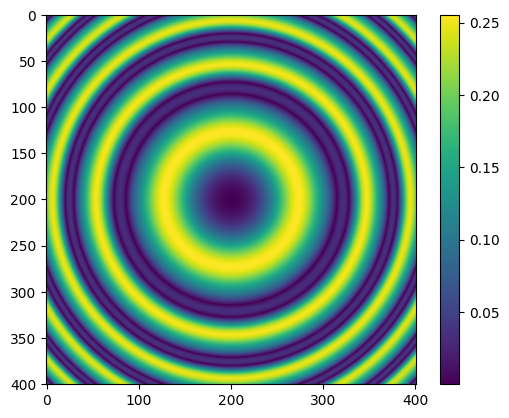

In [16]:
I_transformed1 = np.transpose(P_proj)[0].reshape((401, 401))
I_transformed2 = np.transpose(P_proj)[1].reshape((401, 401))
I_transformed3 = np.transpose(P_proj)[2].reshape((401, 401))


fi_recovered = np.arctan2(np.sqrt(3) * (I_transformed2 - I_transformed3), (I_transformed2 + I_transformed3 - 2*I_transformed1))
fi_unwrapped = unwrap(fi_recovered)
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff_transformed = fi - fi_unwrapped
rmse_transformed = rmse(diff_transformed)
print("transformed", rmse_transformed)

plt.imshow(abs(diff_transformed))
plt.colorbar()

[ 1.68068205  1.53552772  1.38608891  1.23205731  1.07341367  0.9104764
  0.74391498  0.57471028  0.40405514  0.23320882  0.06333696 -0.10462422
 -0.27005047 -0.43264931 -0.59242608 -0.74961541 -0.90459753 -1.05781425
 -1.20969316 -1.36058452 -1.51071328 -1.66014838 -1.80879128 -1.95638539
 -2.10254569 -2.24680506 -2.38867011 -2.52767783 -2.66344396 -2.79569701
 -2.92429549 -3.04922935  3.11257575  2.99453499  2.87953696  2.76722305
  2.65719114  2.54901086  2.44223584  2.33641313  2.23109068  2.12582358
  2.02017995  1.91374713  1.80613907  1.69700527  1.58604172  1.47300373
  1.35772025  1.24010844]


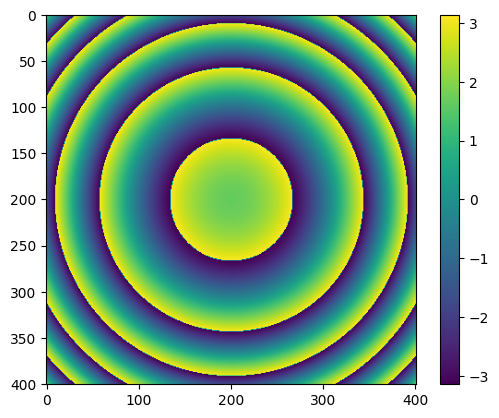

In [17]:
plt.imshow(fi_recovered)
plt.colorbar()
print(fi_recovered[0][:50])

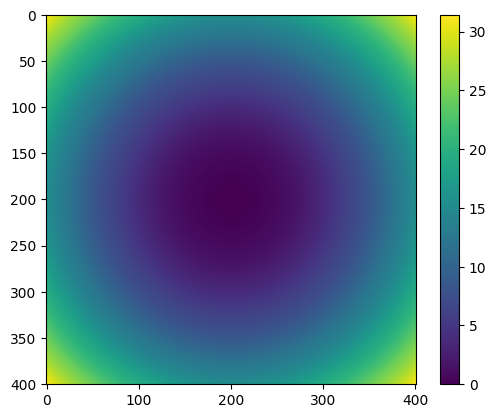

In [18]:
plt.imshow(fi_unwrapped)
plt.colorbar()

In [19]:
I1_flatten = I1.flatten()
I2_flatten = I2.flatten()
I3_flatten = I3.flatten()
number_of_points = I1_flatten.size

P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]   
PT = np.transpose(P)
P_projT = np.transpose(P_proj)

sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
trace3 = go.Scatter3d(x=[O_new[0], S_new[0]], y=[O_new[1], S_new[1]], z=[O_new[2], S_new[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                    color='black',
                                                                                                    width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S_new[0]),
                             y=(P_proj[i][1], S_new[1]),
                             z=(P_proj[i][2], S_new[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show()

In [10]:
file = open("results.csv", "w")
header = "Step error;Noise;Original RMSE;Transformed RMSE;UPSA RMSE\n"
file.write(header)

for i in range(4,11):
    for j in range(2):
        I1 = a1 + b1 * np.cos(fi)
        I2 = a2 + b2 * np.cos(fi + step - (0.2 + j / 5) * step)
        I3 = a3 + b3 * np.cos(fi + 2*step - 2 * (0.2 + j / 5) * step)
        
        I1 = I1 + np.random.normal(0, i / 100, size=(size, size))
        I2 = I2 + np.random.normal(0, i / 100, size=(size, size))
        I3 = I3 + np.random.normal(0, i / 100, size=(size, size))

        P_proj, O_new, S_new = trajectory_search(I1, I2, I3)
        
        I_transformed1 = np.transpose(P_proj)[0].reshape((401, 401))
        I_transformed2 = np.transpose(P_proj)[1].reshape((401, 401))
        I_transformed3 = np.transpose(P_proj)[2].reshape((401, 401))

        fi_recovered = np.arctan2(np.sqrt(3) * (I2 - I3), (I2 + I3 - 2*I1))
        fi_unwrapped = unwrap(fi_recovered)
        fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
        diff_orig = fi - fi_unwrapped
        rmse_orig = rmse(diff_orig)
        print("orig", rmse_orig)
        
        fi_recovered = np.arctan2(np.sqrt(3) * (I_transformed2 - I_transformed3), (I_transformed2 + I_transformed3 - 2*I_transformed1))
        fi_unwrapped = unwrap(fi_recovered)
        fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
        diff_transformed = fi - fi_unwrapped
        rmse_transformed = rmse(diff_transformed)
        print("transformed", rmse_transformed)

        Z4 = upsa(I1, I2, I3)
        fi_recovered = np.arctan2(Z4.real, Z4.imag)
        fi_unwrapped = unwrap(fi_recovered)
        fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
        diff_upsa = fi - fi_unwrapped
        rmse_upsa = rmse(diff_upsa)
        print("upsa", rmse_upsa)
        
        print(" ")
        print("--------")
        print(" ")

        results = str(0.2 * j / 0.1) + ";" + str(i / 10) + ";" + str(rmse_orig) + ";" + str(rmse_transformed) + ";" + str(rmse_upsa) + "\n"
        file.write(results)

file.close()
        

Начальный коэффициент  0.11026272559488058
Итерация 1 ; Коэффициент проекции 0.08199681794408437
Итерация 2 ; Коэффициент проекции 0.08876904493603453
Смена направления
Итерация 3 ; Коэффициент проекции 0.0804285193553278
Итерация 4 ; Коэффициент проекции 0.07669326971910005
Итерация 5 ; Коэффициент проекции 0.07711856413045856
Смена направления
Итерация 6 ; Коэффициент проекции 0.07661689420820099
Итерация 7 ; Коэффициент проекции 0.07638715242679224
Итерация 8 ; Коэффициент проекции 0.07641767212775405
Смена направления
Итерация 9 ; Коэффициент проекции 0.07638623714873691
orig 0.20099664883397322
transformed 0.3400957969976277
upsa 0.15720905356888823
 
--------
 
Начальный коэффициент  0.07985466584722148
Итерация 1 ; Коэффициент проекции 0.07470398633908674
Итерация 2 ; Коэффициент проекции 0.108855477466886
Смена направления
Итерация 3 ; Коэффициент проекции 0.09415012184415122
Итерация 4 ; Коэффициент проекции 0.08347680404250087
Итерация 5 ; Коэффициент проекции 0.0772106673975

In [46]:
file = open("results.txt", "w")
to_write = str(size) + "wqfwdf" + "\n"
file.write(to_write)
file.write("FFF")
file.close()

In [ ]:
sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
trace3 = go.Scatter3d(x=[O_new[0], S_new[0]], y=[O_new[1], S_new[1]], z=[O_new[2], S_new[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S_new[0]),
                                 y=(P_proj[i][1], S_new[1]),
                                 z=(P_proj[i][2], S_new[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show(renderer = 'iframe')

I_transformed1 = np.transpose(P_proj)[0].reshape((401, 401))
I_transformed2 = np.transpose(P_proj)[1].reshape((401, 401))
I_transformed3 = np.transpose(P_proj)[2].reshape((401, 401))

fi_recovered = np.arctan2(-np.sqrt(3) * (I2 - I3), (I2 + I3 - 2*I1))
fi_unwrapped = unwrap(fi_recovered)
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff = fi - fi_unwrapped
print("orig", rmse(diff))

fi_recovered = np.arctan2(-np.sqrt(3) * (I_transformed2 - I_transformed3), (I_transformed2 + I_transformed3 - 2*I_transformed1))
fi_unwrapped = unwrap(fi_recovered)
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff = fi - fi_unwrapped
print("transformed", rmse(diff))

In [11]:
I1_flatten = I1.flatten()
I2_flatten = I2.flatten()
I3_flatten = I3.flatten()

S = np.array([np.mean(I1_flatten), np.mean(I2_flatten), 6*np.mean(I3_flatten)])

number_of_points = I1_flatten.size
P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]   
PT = np.transpose(P)

R = S - P

P_vec_norm = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P_vec_norm[i] = S - P[i]
P_vec_norm = normalize_matrix(P_vec_norm)
O = np.array([0., 0., 0.])
for i in range(number_of_points):
    O[0] += P_vec_norm[i][0]
    O[1] += P_vec_norm[i][1]
    O[2] += P_vec_norm[i][2]
O[0] /= number_of_points / 5
O[1] /= number_of_points / 5
O[2] /= number_of_points / 5  
O = S - O

# ---------  Параметры Изначальной Плоскости --------
# Нормаль на плоскость
directional_vector = np.array([(S[0] - O[0]), (S[1] - O[1]), (S[2] - O[2])]) 
    
# Компоненты уравнения плоскости перпендикулярной оси
plane1_x = directional_vector[0]
plane1_y = directional_vector[1]
plane1_z = directional_vector[2]
plane1_D = -(directional_vector[0] * O[0]) - (directional_vector[1] * O[1]) - (directional_vector[2] * O[2])
# ---------------------------------------------------

# расчет первой проекции
P_proj = projection(P, O, S, number_of_points)
print("Коэффициент эллиптической траектории - ", K_form(P, number_of_points))
form_initial = K_form(P_proj, number_of_points)
form_projection = form_initial
print("Коэффициент изначальной проекции - ", form_initial)

#  ----------- Находим большую ось эллипса, находя две наиболее удаленные от центра точки ------------
center = np.array([0.0, 0.0, 0.0])
center[0] = np.mean(PT[0])
center[1] = np.mean(PT[1])
center[2] = np.mean(PT[2])

radii = np.empty([number_of_points])
for i in range(number_of_points):
    radii[i] = np.linalg.norm(P[i] - center)    
index1 = np.argmax(radii)
point1 = P[index1]
radii[index1] = 0
radius1 = np.linalg.norm(point1 - O)

while True:
    index2 = np.argmax(radii)
    point2 = P[index2]
    if np.linalg.norm(point2 - point1) > radius1: break
    radii[index2] = 0

point3 = point1 - point2

point3[2] = 0.0
# ------------------------------------------------------------------------------------------------

form_best = form_initial

E = 0.005
step = 0.45
direction = 1
iteration = 0
misses = 0
while form_projection > E:
    iteration += 1
    
    # Находим новую точку S
    S_new = S + step*point3*direction
    #S_new[2] -= np.sqrt(point3[0]**2 + point3[1]**2)
    axis_length = np.linalg.norm(S_new - O)
    
    # Находим новую точку O
    P_vec_norm = np.empty([number_of_points, 3])
    for i in range(number_of_points):
        P_vec_norm[i] = S_new - P[i]
    P_vec_norm = normalize_matrix(P_vec_norm)
    O_new = np.array([0., 0., 0.])
    for i in range(number_of_points):
        O_new[0] += P_vec_norm[i][0]
        O_new[1] += P_vec_norm[i][1]
        O_new[2] += P_vec_norm[i][2]
    O_new[0] /= number_of_points / axis_length
    O_new[1] /= number_of_points / axis_length
    O_new[2] /= number_of_points / axis_length
    O_new = S_new - O_new
    
    # ---------  Параметры новой плоскости проекции Плоскости --------
    # Нормаль на плоскость
    directional_vector = np.array([(S_new[0] - O_new[0]), (S_new[1] - O_new[1]), (S_new[2] - O_new[2])]) 
        
    # Компоненты уравнения плоскости перпендикулярной оси
    plane1_x = directional_vector[0]
    plane1_y = directional_vector[1]
    plane1_z = directional_vector[2]
    plane1_D = -(directional_vector[0] * O_new[0]) - (directional_vector[1] * O_new[1]) - (directional_vector[2] * O_new[2])
    # ---------------------------------------------------
    
    # расчет новой плоскости проекции
    P_proj = projection(P, O_new, S_new, number_of_points)
    form_projection = K_form(P_proj, number_of_points)
    print("Итерация ", iteration, "; Коэффициент новой проекции - ", form_projection)
    if form_projection > form_initial:
        direction *= -1
        misses += 1
        print("Смена направления")
    if form_projection < form_best:
        form_best = form_projection
        S_best = S_new
        O_best = O_new
    
    PT = np.transpose(P)
    P_projT = np.transpose(P_proj)

    sliced = range(0, number_of_points, 500)
    trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
    trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
    trace3 = go.Scatter3d(x=[O_new[0], S_new[0]], y=[O_new[1], S_new[1]], z=[O_new[2], S_new[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
    drawings = [trace1, trace2, trace3]

    for i in range(0, I1.flatten().size, 4000):
        drawings.append(go.Scatter3d(x=(P_proj[i][0], S_new[0]),
                                 y=(P_proj[i][1], S_new[1]),
                                 z=(P_proj[i][2], S_new[2]), mode='lines',  marker=dict(size=4)))

    fig = go.Figure(drawings)
    fig.show()

    if misses >= 2:
        #step *= 0.25
        misses = 0
    if iteration >= 20:
        S_new = S_best
        O_new = S_best
        print("Прерывание, возращение к проекции с коэффициентом ", form_best)
        break

    step = step * 0.9
    O = O_new
    S = S_new
    form_initial = form_projection
    

Коэффициент эллиптической траектории -  0.016817819115520643
Коэффициент изначальной проекции -  0.08410881277863018
Итерация  1 ; Коэффициент новой проекции -  0.08486673279284745
Смена направления


KeyboardInterrupt: 

In [12]:
P_proj = projection(P, O_new, S_new, number_of_points)

PT = np.transpose(P)
P_projT = np.transpose(P_proj)
sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
trace3 = go.Scatter3d(x=[O_new[0], S_new[0]], y=[O_new[1], S_new[1]], z=[O_new[2], S_new[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                        color='black',
                                                                                                        width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1.flatten().size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S_new[0]),
                                 y=(P_proj[i][1], S_new[1]),
                                 z=(P_proj[i][2], S_new[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.show()

LinAlgError: Singular matrix

In [ ]:
I_transformed1 = np.transpose(P_proj)[0].reshape((401, 401))
I_transformed2 = np.transpose(P_proj)[1].reshape((401, 401))
I_transformed3 = np.transpose(P_proj)[2].reshape((401, 401))

fi_recovered = np.arctan2(-np.sqrt(3) * (I2 - I3), (I2 + I3 - 2*I1))
fi_unwrapped = unwrap(fi_recovered)
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff = fi - fi_unwrapped
print("orig", rmse(diff))

fi_recovered = np.arctan2(-np.sqrt(3) * (I_transformed2 - I_transformed3), (I_transformed2 + I_transformed3 - 2*I_transformed1))
fi_unwrapped = unwrap(fi_recovered)
fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
diff = fi - fi_unwrapped
print("transformed", rmse(diff))

# Trajectory Search AI

In [ ]:
# На вход интерферограммы
# На выходе вершина
# Задача - Регрессия
# Метод обучения - без учителя

In [ ]:
# Создать датасет

In [10]:
size = 512
number_of_points = size * size
step = 2 * np.pi / 3 #pi/4

fi = np.empty([size, size])
a1 = np.empty([size, size])
b1 = np.empty([size, size])
a2 = np.empty([size, size])
b2 = np.empty([size, size])
a3 = np.empty([size, size])
b3 = np.empty([size, size])

for i in range(size):
    for j in range(size):
        x = i / (size / 2) - 1
        y = j / (size / 2) - 1
        fi[i][j] = 5 * np.pi * (x**2 + y**2)
        a1[i][j] = np.exp(-0.02 * (x**2 + y**2))
        b1[i][j] = 0.9 * np.exp(-0.02 * (x**2 + y**2))
        a2[i][j] = 0.95 * np.exp(-0.02 * (x**2 + y**2))
        b2[i][j] = 0.85 * np.exp(-0.02 * (x**2 + y**2))
        a3[i][j] = 0.9 * np.exp(-0.02 * (x**2 + y**2))
        b3[i][j] = 0.8 * np.exp(-0.02 * (x**2 + y**2))

number_of_examples = 30
number_of_phase_shift_errors = 10
number_of_noise_levels = 3
dataset_X = np.empty([number_of_examples, size, size, 3])
dataset_y = np.empty([number_of_examples, 3])

current_example = 0
for noise_level in range(number_of_noise_levels):
    for phase_error in range(number_of_phase_shift_errors):
        images = np.empty([3, size, size])
        images[0] = a1 + b1 * np.cos(fi + np.random.normal(0, noise_level / 100, size=(size, size)))
        images[1] = a2 + b2 * np.cos(fi + step - (phase_error / 10) + np.random.normal(0, noise_level / 100, size=(size, size)))
        images[2] = a3 + b3 * np.cos(fi + 2*step - 2*(phase_error / 10) + np.random.normal(0, noise_level / 100, size=(size, size)))
        images = np.moveaxis(images, 0, -1)
        dataset_X[current_example] = images
        dataset_y[current_example] = [0.0, 0.0, 0.0]
        current_example += 1

dataset_X = np.float32(dataset_X)
dataset_y = np.float32(dataset_y)

# Сгенерирован датасет 50 примеров, комбинации 10 уровней ошибки фазового сдвига и 5 уровней шума (0,1,2,3,4 %)

In [5]:
def custom_loss(input_tensor, y_pred):
    reshaped_input = tf.reshape(input_tensor, (-1, 3))
    O = tf.reduce_mean(reshaped_input, axis=0)
    L = tf.subtract(O, y_pred)
    R = tf.subtract(reshaped_input, y_pred)
    L_norm = tf.norm(L)
    R_norm = tf.norm(R, axis=1)
    numerator = tf.reduce_sum(tf.multiply(L, R), axis=1)
    denominator = tf.multiply(L_norm, R_norm)
    angles = tf.divide(numerator, denominator)
    angles = tf.divide(
       tf.subtract(angles, tf.reduce_min(angles)), 
       tf.subtract(tf.reduce_max(angles), tf.reduce_min(angles))
    )
    return tf.math.reduce_variance(angles)

In [38]:
inp = layers.Input(shape=(512,512,3), dtype=tf.float32)
out = layers.Dense(3)
model = keras.Sequential([
  inp,
  layers.Conv2D(3, 3, activation='selu', padding='same'),
  layers.Conv2D(6, 3, activation='selu', padding='same'),
  layers.AvgPool2D(2),
  layers.Conv2D(6, 3, activation='selu', padding='same'),
  layers.Conv2D(12, 3, activation='selu', padding='same'),
  layers.AvgPool2D(2),
  layers.Conv2D(24, 3, activation='selu', padding='same'),
  layers.AvgPool2D(2),
  layers.Conv2D(48, 3, activation='selu', padding='same'),
  layers.AvgPool2D(2),
  layers.Conv2D(64, 3, activation='selu', padding='same'),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  out
])
#model = keras.Sequential([
#    inp,
#    layers.Conv2D(3, 3, activation='selu', padding='same'),
#    layers.Flatten(),
#    layers.Dense(36, activation='relu'),
#    layers.Dense(18, activation='relu'),
#    out,
#])
model.build()
model.summary()
# На входе интерферограммы
# На выходе точка вершины
# Оптимизация разброса углов
# Лучше решить простым градиентным спуском без нейросети
# Результаты тестирования нейросети для статьи

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)                   │ (None, 512, 512, 3)         │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 512, 512, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_20                 │ (None, 256, 256, 6)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 256, 256, 6)         │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 256, 256, 12)        │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_21                 │ (None, 128, 128, 12)        │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 128, 128, 24)        │           2,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_22                 │ (None, 64, 64, 24)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 64, 64, 48)          │          10,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_23                 │ (None, 32, 32, 48)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 32, 32, 64)          │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │       4,194,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,236,549 (16.16 MB)

 Trainable params: 4,236,549 (16.16 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(model, inputs):
    with tf.GradientTape() as tape:
        y_pred = model(inputs, training=True)
        loss = custom_loss(inputs, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

for epoch in range(20):
    for inputs in dataset_X:  
        inputs = tf.expand_dims(inputs, axis=0)
        inputs = tf.get_static_value(inputs)
        loss = train_step(model, inputs)
    print(f"Epoch {epoch + 1}: Loss = {loss.numpy()}")

Epoch 1: Loss = 0.04588693007826805
Epoch 2: Loss = 0.024613404646515846
Epoch 3: Loss = 0.024818135425448418
Epoch 4: Loss = 0.038177117705345154
Epoch 5: Loss = 0.0542343407869339
Epoch 6: Loss = 0.01553282793611288
Epoch 7: Loss = 0.04668286070227623
Epoch 8: Loss = 0.07977689802646637
Epoch 9: Loss = 0.1221909373998642
Epoch 10: Loss = 0.02795466035604477
Epoch 11: Loss = 0.03519097715616226
Epoch 12: Loss = 0.1173819750547409
Epoch 13: Loss = 0.059932488948106766
Epoch 14: Loss = 0.03191646561026573
Epoch 15: Loss = 0.03757201135158539
Epoch 16: Loss = 0.047182176262140274
Epoch 17: Loss = 0.12303072214126587
Epoch 18: Loss = 0.04781823977828026
Epoch 19: Loss = 0.08611252158880234
Epoch 20: Loss = 0.1540716588497162


In [40]:
images_test = dataset_X[27]
images_test = np.moveaxis(images_test, -1, 0)
print(images_test.shape)
I1_flatten = images_test[0].flatten()
I2_flatten = images_test[1].flatten()
I3_flatten = images_test[2].flatten()
number_of_points = I1_flatten.size

P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]   
PT = np.transpose(P)

O = np.array([0.0, 0.0, 0.0])
O[0] = np.mean(PT[0])
O[1] = np.mean(PT[1])
O[2] = np.mean(PT[2])

S_test = model.predict(dataset_X)[25]
print(S_test.shape)

P_proj = projection(P, O, S_test, number_of_points)
P_projT = np.transpose(P_proj)
form_initial = K_form(P, number_of_points)
form_projection = K_form(P_proj, number_of_points)
print(form_initial, form_projection)

sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
trace3 = go.Scatter3d(x=[O[0], S_test[0]], y=[O[1], S_test[1]], z=[O[2], S_test[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                    color='black',
                                                                                                    width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1_flatten.size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S_test[0]),
                             y=(P_proj[i][1], S_test[1]),
                             z=(P_proj[i][2], S_test[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.update_layout(width=700, margin=dict(r=10, l=10, b=10, t=10))
# fix the ratio in the top left subplot to be a cube
fig.update_layout(scene_aspectmode='data')
fig.show()

IndexError: index 27 is out of bounds for axis 0 with size 20

# Trajectory gradient descent + ellipse fitting

In [11]:
def custom_loss(input_tensor, y_pred):
    reshaped_input = tf.reshape(input_tensor, (-1, 3))
    O = tf.reduce_mean(reshaped_input, axis=0)
    L = tf.subtract(O, y_pred)
    R = tf.subtract(reshaped_input, y_pred)
    L_norm = tf.norm(L)
    R_norm = tf.norm(R, axis=1)
    numerator = tf.reduce_sum(tf.multiply(L, R), axis=1)
    denominator = tf.multiply(L_norm, R_norm)
    angles = tf.divide(numerator, denominator)
    angles = tf.divide(
       tf.subtract(angles, tf.reduce_min(angles)), 
       tf.subtract(tf.reduce_max(angles), tf.reduce_min(angles))
    )
    return tf.math.reduce_variance(angles)

In [12]:
def vertex_gradient_descent(I1, I2, I3):
    I1_flatten = I1.flatten()
    I2_flatten = I2.flatten()
    I3_flatten = I3.flatten()
    
    number_of_points = I1_flatten.size
    P = np.empty([number_of_points, 3])
    for i in range(number_of_points):
        P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]
    #  ----------- Находим большую ось эллипса, находя две наиболее удаленные от центра точки ------------
    O = np.array([0.0, 0.0, 0.0])
    O[0] = np.mean(I1)
    O[1] = np.mean(I1)
    O[2] = np.mean(I1)
    
    radii = np.empty([number_of_points])
    for i in range(number_of_points):
        radii[i] = np.linalg.norm(P[i] - O)    
    index1 = np.argmax(radii)
    point1 = P[index1]
    radii[index1] = 0
    radius1 = np.linalg.norm(point1 - O)
    
    while True:
        index2 = np.argmax(radii)
        point2 = P[index2]
        if np.linalg.norm(point2 - point1) > radius1: break
        radii[index2] = 0
    # --------------------------------------------------------------------------------------------------
    
    # Напраление малой оси эллпса
    radii = np.empty([number_of_points])
    for i in range(number_of_points):
        radii[i] = np.linalg.norm(P[i] - O)   
    index3 = np.argmin(radii)
    point3 = P[index3]
    
    # Находим нормаль эллипса по трем точкам
    cone_axis = np.cross(point2 - point1, point2 - point3)
    cone_axis = normalize_matrix([cone_axis])[0]
    
    # Начальная вершина
    S = O - 6*cone_axis
    
    # Инициализация y_pred и оптимизатора
    y_pred = tf.Variable([S[0], S[1], S[2]], dtype=tf.float32)  # Начальная точка
    #y_pred = tf.Variable([0.0, 0.0, 0.0], dtype=tf.float32)
    print(f"start = {y_pred.numpy}")
    learning_rate = 0.3
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1 = 0.1, beta_2 = 0.4)
    
    example = np.empty([3, size, size])
    example[0] = I1
    example[1] = I2
    example[2] = I3
    example = np.moveaxis(example, 0, -1)
    print(example.shape)
    example = tf.convert_to_tensor(example, dtype=tf.float32)

    prev_loss = 0
    for epoch in range(40):
        with tf.GradientTape() as tape:
            loss = custom_loss(example, y_pred)
            gradients = tape.gradient(loss, [y_pred])
        #if epoch > 0 and prev_loss - loss.numpy() < 0.001 and prev_loss - loss.numpy() > 0 and learning_rate < 20:
        #    learning_rate = learning_rate*5
        #    optimizer.learning_rate.assign(learning_rate)
        #    print(f"learning_rate = {learning_rate}")
        optimizer.apply_gradients(zip(gradients, [y_pred]))
        print(f"Epoch {epoch + 1}: Loss = {loss.numpy()}  S = {y_pred.numpy()}")
        prev_loss = loss.numpy()
    return y_pred.numpy()

In [13]:
images_test = dataset_X[17]
images_test = np.moveaxis(images_test, -1, 0)
print(images_test.shape)

S_test = vertex_gradient_descent(images_test[0], images_test[1], images_test[2])

(3, 512, 512)
start = <bound method BaseResourceVariable.numpy of <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([-2.9239213,  2.075078 , -3.446915 ], dtype=float32)>>
(512, 512, 3)
Epoch 1: Loss = 0.08622506260871887  S = [-2.6239238  2.3750713 -3.746912 ]
Epoch 2: Loss = 0.07776105403900146  S = [-2.3458748  2.622691  -3.9943664]
Epoch 3: Loss = 0.07308612018823624  S = [-2.0889692  2.726048  -4.2050586]
Epoch 4: Loss = 0.07015036046504974  S = [-1.8242822  2.7567923 -4.414106 ]
Epoch 5: Loss = 0.06777161359786987  S = [-1.5702279  2.692338  -4.614946 ]
Epoch 6: Loss = 0.06610691547393799  S = [-1.3349826  2.700399  -4.7971406]
Epoch 7: Loss = 0.06508882343769073  S = [-1.131254  2.755213 -4.977128]
Epoch 8: Loss = 0.06436131149530411  S = [-0.9231775  3.055456  -5.1795893]
Epoch 9: Loss = 0.06398608535528183  S = [-0.8235994  2.7467787 -5.4454627]
Epoch 10: Loss = 0.0637521743774414  S = [-0.8555799  3.0157652 -5.682068 ]
Epoch 11: Loss = 0.0634356439113617  S = [-0

In [15]:
file = open("results_gradient.csv", "w")
header = "Iteration;Original RMSE;Transformed RMSE\n"
file.write(header)

iteration = 0
for example in dataset_X:
    example = np.moveaxis(example, -1, 0)
    S_test = vertex_gradient_descent(example[0], example[1], example[2])
    
    I1_flatten = example[0].flatten()
    I2_flatten = example[1].flatten()
    I3_flatten = example[2].flatten()
    number_of_points = I1_flatten.size
    
    P = np.empty([number_of_points, 3])
    for i in range(number_of_points):
        P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]   
    PT = np.transpose(P)
    
    O = np.array([0.0, 0.0, 0.0])
    O[0] = np.mean(PT[0])
    O[1] = np.mean(PT[1])
    O[2] = np.mean(PT[2])
    
    P_proj = projection(P, O, S_test, number_of_points)
    P_projT = np.transpose(P_proj)
    form_initial = K_form(P, number_of_points)
    form_projection = K_form(P_proj, number_of_points)
    print(form_initial, form_projection)
    
    I_transformed1 = np.transpose(P_proj)[0].reshape((size, size))
    I_transformed2 = np.transpose(P_proj)[1].reshape((size, size))
    I_transformed3 = np.transpose(P_proj)[2].reshape((size, size))

    fi_recovered = np.arctan2(np.sqrt(3) * (I_transformed2 - I_transformed3), (I_transformed2 + I_transformed3 - 2*I_transformed1))
    fi_unwrapped = unwrap(fi_recovered)
    fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
    diff_transformed = fi - fi_unwrapped
    rmse_transformed = rmse(diff_transformed)

    fi_recovered = np.arctan2(np.sqrt(3) * (example[1] - example[2]), (example[1] + example[2] - 2*example[0]))
    fi_unwrapped = unwrap(fi_recovered)
    fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
    diff_orig = fi - fi_unwrapped
    rmse_orig = rmse(diff_orig)

    file.write(f"{iteration};{rmse_orig};{rmse_transformed}\n")

    iteration += 1

file.close()


start = <bound method BaseResourceVariable.numpy of <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([4.0824246, 4.4556646, 4.753799 ], dtype=float32)>>
(512, 512, 3)
Epoch 1: Loss = 0.07260756194591522  S = [3.782427  4.1556754 5.053796 ]
Epoch 2: Loss = 0.06353814899921417  S = [3.5050893 3.8364043 5.319486 ]
Epoch 3: Loss = 0.05945918709039688  S = [3.3852055 3.7939332 5.2969356]
Epoch 4: Loss = 0.05939848721027374  S = [3.4716692 3.832874  5.104073 ]
Epoch 5: Loss = 0.059309691190719604  S = [3.2540302 3.5296588 5.1718235]
Epoch 6: Loss = 0.060039542615413666  S = [3.5162587 3.848012  4.8433037]
Epoch 7: Loss = 0.06059103459119797  S = [3.2105072 3.6036818 5.079845 ]
Epoch 8: Loss = 0.059338536113500595  S = [3.4245315 3.7028966 4.845451 ]
Epoch 9: Loss = 0.05915859341621399  S = [3.1753278 3.454056  5.0001554]
Epoch 10: Loss = 0.059623491019010544  S = [3.409871  3.7527769 4.691222 ]
Epoch 11: Loss = 0.06004711240530014  S = [3.140545  3.4848464 4.9212523]
Epoch 12:

In [9]:
I1_flatten = images_test[0].flatten()
I2_flatten = images_test[1].flatten()
I3_flatten = images_test[2].flatten()
number_of_points = I1_flatten.size

P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]   
PT = np.transpose(P)

O = np.array([0.0, 0.0, 0.0])
O[0] = np.mean(PT[0])
O[1] = np.mean(PT[1])
O[2] = np.mean(PT[2])

P_proj = projection(P, O, S_test, number_of_points)
P_projT = np.transpose(P_proj)
form_initial = K_form(P, number_of_points)
form_projection = K_form(P_proj, number_of_points)
print(form_initial, form_projection)

sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
trace3 = go.Scatter3d(x=[O[0], S_test[0]], y=[O[1], S_test[1]], z=[O[2], S_test[2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                    color='black',
                                                                                                    width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1_flatten.size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S_test[0]),
                             y=(P_proj[i][1], S_test[1]),
                             z=(P_proj[i][2], S_test[2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.update_layout(width=700, margin=dict(r=10, l=10, b=10, t=10))
# fix the ratio in the top left subplot to be a cube
fig.update_layout(scene_aspectmode='data')
fig.show()

0.15121253254970565 0.05818225183423673


In [6]:
size = 512
step = 2 * np.pi / 3 #pi/4

fi = np.empty([size, size])
a1 = np.empty([size, size])
b1 = np.empty([size, size])
a2 = np.empty([size, size])
b2 = np.empty([size, size])
a3 = np.empty([size, size])
b3 = np.empty([size, size])

for i in range(size):
    for j in range(size):
        x = i / (size / 2) - 1
        y = j / (size / 2) - 1
        fi[i][j] = 5 * np.pi * (x**2 + y**2)
        a1[i][j] = np.exp(-0.02 * (x**2 + y**2))
        b1[i][j] = 0.9 * np.exp(-0.02 * (x**2 + y**2))
        a2[i][j] = 0.95 * np.exp(-0.02 * (x**2 + y**2))
        b2[i][j] = 0.85 * np.exp(-0.02 * (x**2 + y**2))
        a3[i][j] = 0.9 * np.exp(-0.02 * (x**2 + y**2))
        b3[i][j] = 0.8 * np.exp(-0.02 * (x**2 + y**2))
        
images_test = np.empty([3, size, size])
images_test[0] = a1 + b1 * np.cos(fi)
images_test[1] = a2 + b2 * np.cos(fi + step - step*(20/60))
images_test[2] = a3 + b3 * np.cos(fi + 2*step - 2*step*(20/60))
I1_flatten = images_test[0].flatten()
I2_flatten = images_test[1].flatten()
I3_flatten = images_test[2].flatten()

In [ ]:
def fit_ellipse_3d(x, y, z):
    # Центрируем точки
    x_mean, y_mean, z_mean = np.mean(x), np.mean(y), np.mean(z)
    x, y, z = x - x_mean, y - y_mean, z - z_mean
    
    # Составляем матрицу данных
    D = np.vstack((
        x**2, y**2, z**2, 
        2*x*y, 2*x*z, 2*y*z, 
        x, y, z, 
        np.ones_like(x)
    )).T  # Размер (N, 10)
    
    # Уравнение эллипса: A*x^2 + B*y^2 + C*z^2 + D*xy + E*xz + F*yz + G*x + H*y + I*z + J = 0
    def ellipse_residuals(params):
        # Умножаем матрицу D (N, 10) на params (10,)
        return np.sum((D @ params)**2)  # Сумма квадратов ошибо
    
    # Минимизируем
    params0 = np.ones(10)  # Начальное приближение
    result = scipy.optimize.minimize(ellipse_residuals, params0, method='L-BFGS-B')
    
    if not result.success:
        raise RuntimeError("Фитинг эллипса не удался: " + result.message)
    
    params = result.x
    return params, x_mean, y_mean, z_mean

def project_to_ellipse(x, y, z, params, x_mean, y_mean, z_mean):
    # Проекция точки на поверхность эллипса
    A, B, C, D, E, F, G, H, I, J = params
    points = np.vstack((x - x_mean, y - y_mean, z - z_mean)).T
    
    projected_points = []
    for point in points:
        def dist_to_ellipse(p):
            px, py, pz = p
            return np.linalg.norm([px - point[0], py - point[1], pz - point[2]])**2
        
        # Ограничение: точка должна лежать на эллипсе
        constraints = {
            'type': 'eq',
            'fun': lambda p: A*p[0]**2 + B*p[1]**2 + C*p[2]**2 + D*p[0]*p[1] +
                             E*p[0]*p[2] + F*p[1]*p[2] + G*p[0] + H*p[1] + I*p[2] + J
        }
        # Находим ближайшую точку на эллипсе
        p0 = point  # начальное приближение
        res = scipy.optimize.minimize(dist_to_ellipse, p0, constraints=[constraints])
        projected_points.append(res.x)
    
    return np.array(projected_points) + np.array([x_mean, y_mean, z_mean])



params, x_mean, y_mean, z_mean = fit_ellipse_3d(I1_flatten, I1_flatten, I1_flatten)
projected_points = project_to_ellipse(I1_flatten, I1_flatten, I1_flatten, params, x_mean, y_mean, z_mean)

I1_fitted, I2_fitted, I3_fitted = projected_points.T

In [ ]:
number_of_points = I1_flatten.size

P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]   
PT = np.transpose(P)

sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))

drawings = [trace1]

fig = go.Figure(drawings)
fig.update_layout(width=700, margin=dict(r=10, l=10, b=10, t=10))
# fix the ratio in the top left subplot to be a cube
fig.update_layout(scene_aspectmode='data')
fig.show()

In [ ]:
y_pred = vertex_gradient_descent(images_test[0], images_test[1], images_test[2])
S_test = np.expand_dims(y_pred, 0)

In [ ]:
I1_flatten = images_test[0].flatten()
I2_flatten = images_test[1].flatten()
I3_flatten = images_test[2].flatten()
number_of_points = I1_flatten.size

P = np.empty([number_of_points, 3])
for i in range(number_of_points):
    P[i] = [I1_flatten[i], I2_flatten[i], I3_flatten[i]]   
PT = np.transpose(P)

O = np.array([0.0, 0.0, 0.0])
O[0] = np.mean(PT[0])
O[1] = np.mean(PT[1])
O[2] = np.mean(PT[2])

P_proj = projection(P, O, S_test[0], number_of_points)
P_projT = np.transpose(P_proj)
form_initial = K_form(P, number_of_points)
form_projection = K_form(P_proj, number_of_points)
print(form_initial, form_projection)

sliced = range(0, number_of_points, 500)
trace1 = go.Scatter3d(x=PT[0][sliced], y=PT[1][sliced], z=PT[2][sliced], mode='markers', marker=dict(size=2))
trace2 = go.Scatter3d(x=P_projT[0][sliced], y=P_projT[1][sliced], z=P_projT[2][sliced], mode='markers', marker=dict(size=2))
trace3 = go.Scatter3d(x=[O[0], S_test[0][0]], y=[O[1], S_test[0][1]], z=[O[2], S_test[0][2]], mode='lines',  marker=dict(size=4), line=dict(
                                                                                                    color='black',
                                                                                                    width=5))
drawings = [trace1, trace2, trace3]

for i in range(0, I1_flatten.size, 4000):
    drawings.append(go.Scatter3d(x=(P_proj[i][0], S_test[0][0]),
                             y=(P_proj[i][1], S_test[0][1]),
                             z=(P_proj[i][2], S_test[0][2]), mode='lines',  marker=dict(size=4)))

fig = go.Figure(drawings)
fig.update_layout(width=700, margin=dict(r=10, l=10, b=10, t=10))
# fix the ratio in the top left subplot to be a cube
fig.update_layout(scene_aspectmode='data')
fig.show()

# VU_Matrices

In [10]:
def test_noise_VU(mean, deviation, criterion):
    I1_test = I1 + np.random.normal(mean, deviation, size=(size, size))
    I2_test = I2 + np.random.normal(mean, deviation, size=(size, size))
    I3_test = I3 + np.random.normal(mean, deviation, size=(size, size))
    
    I_M = np.matrix([I1_test.flatten(), I2_test.flatten(), I3_test.flatten()]).transpose()
    U_M = np.matrix([[1, 1, 1], 
                     [np.cos(0), np.cos(np.pi), np.cos(1.8*np.pi)],
                     [np.sin(0), np.sin(np.pi), np.sin(1.8*np.pi)]]).transpose()
    V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1
    phase_change_2 = np.arctan2(-V_M[:, 2], V_M[:, 1])
    stop = abs(phase_change_2.mean()) + 1

    while stop > criterion:
        V_M[:, 1] = np.cos(phase_change_2)
        V_M[:, 2] = -np.sin(phase_change_2)
        U_M = (((V_M.transpose() * V_M) ** -1) * V_M.transpose() * I_M).transpose()
        V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1
        phase_change_1 = np.arctan2(-V_M[:, 2], V_M[:, 1])
        
        V_M[:, 1] = np.cos(phase_change_1)
        V_M[:, 2] = -np.sin(phase_change_1)
        U_M = (((V_M.transpose() * V_M) ** -1) * V_M.transpose() * I_M).transpose()
        V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1
        phase_change_2 = np.arctan2(-V_M[:, 2], V_M[:, 1])
        
        stop = abs((np.array(phase_change_2 - phase_change_1) ** 2).mean())
        
    fi_recovered = phase_change_2.reshape((401, -1))   
    fi_unwrapped = unwrap(fi_recovered)
    fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
    diff = fi - fi_unwrapped
    return rmse(diff)

def test_step_error_VU(error, criterion):
    I1_test = a1 + b1 * np.cos(fi)
    I2_test = a2 + b2 * np.cos(fi + step + (np.random.rand() - 0.5) * error)
    I3_test = a3 + b3 * np.cos(fi + 2*(step + (np.random.rand() - 0.5) * error))
    
    I_M = np.matrix([I1_test.flatten(), I2_test.flatten(), I3_test.flatten()]).transpose()
    U_M = np.matrix([[1, 1, 1], 
                     [np.cos(0), np.cos(np.pi), np.cos(1.8*np.pi)],
                     [np.sin(0), np.sin(np.pi), np.sin(1.8*np.pi)]]).transpose()
    V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1
    phase_change_2 = np.arctan2(-V_M[:, 2], V_M[:, 1])
    stop = abs(phase_change_2.mean()) + 1

    while stop > criterion:
        V_M[:, 1] = np.cos(phase_change_2)
        V_M[:, 2] = -np.sin(phase_change_2)
        U_M = (((V_M.transpose() * V_M) ** -1) * V_M.transpose() * I_M).transpose()
        V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1
        phase_change_1 = np.arctan2(-V_M[:, 2], V_M[:, 1])
        
        V_M[:, 1] = np.cos(phase_change_1)
        V_M[:, 2] = -np.sin(phase_change_1)
        U_M = (((V_M.transpose() * V_M) ** -1) * V_M.transpose() * I_M).transpose()
        V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1
        phase_change_2 = np.arctan2(-V_M[:, 2], V_M[:, 1])
        
        stop = abs((np.array(phase_change_2 - phase_change_1) ** 2).mean())
        
    fi_recovered = phase_change_2.reshape((401, -1))   
    fi_unwrapped = unwrap(fi_recovered)
    fi_unwrapped = fi_unwrapped - fi_unwrapped.min()
    diff = fi - fi_unwrapped
    return rmse(diff)

In [49]:
for i in range(26):
    result = 0
    for j in range(10):
        np.random.seed(j)
        result += test_noise_VU(0, i/100, 0.000001)
    print('\n', i, '% rme = ', result / 10)


 0 % rme =  0.002739656247119484

 1 % rme =  0.023955907972307025

 2 % rme =  0.05152413738510538

 3 % rme =  0.07982708444670135

 4 % rme =  0.10850250211590755

 5 % rme =  0.13732144274862962

 6 % rme =  0.16615222364980856

 7 % rme =  0.19525567176734798

 8 % rme =  0.22439837970526652

 9 % rme =  0.2539686149316874

 10 % rme =  0.2836633050722226

 11 % rme =  0.313575788221387

 12 % rme =  0.3433098078477718

 13 % rme =  0.3728014364730812

 14 % rme =  0.40289146898251393

 15 % rme =  0.4340695177565713

 16 % rme =  0.46544379769602023

 17 % rme =  0.4970167540599748

 18 % rme =  0.5298934207005136

 19 % rme =  0.5655482358122168

 20 % rme =  0.6055669096351772

 21 % rme =  0.6460591028678242

 22 % rme =  0.6876349454687245

 23 % rme =  0.8748629424487641

 24 % rme =  1.2786866626738065

 25 % rme =  0.8191882191879811


In [11]:
for i in range(11):
    result = 0
    for j in range(10):
        np.random.seed(j)
        result += test_step_error_VU(i/10, 0.000001)
    print('\n', i/10, 'rad rme = ', result / 10)


 0.0 rad rme =  0.002739656247119484

 0.1 rad rme =  0.0027380439716989725

 0.2 rad rme =  0.0025325873144099943

 0.3 rad rme =  0.002678880448164791

 0.4 rad rme =  0.002621526471017655

 0.5 rad rme =  0.0025723377651668297

 0.6 rad rme =  0.0026968989851241373

 0.7 rad rme =  0.002682755650185735

 0.8 rad rme =  0.002666984205215268

 0.9 rad rme =  0.002622016079647021

 1.0 rad rme =  0.002751287690897394


In [48]:
I_M = np.matrix([I1.flatten(), I2.flatten(), I3.flatten()]).transpose()
U_M = np.matrix([[1, 1, 1], 
                 [np.cos(0), np.cos(np.pi), np.cos(2.1*np.pi)],
                 [np.sin(0), np.sin(np.pi), np.sin(1.8*np.pi)]])
V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1

In [49]:
phase_change = np.arctan2(-V_M[:, 2], V_M[:, 1])
recovered_phase = phase_change.reshape((401, -1))

In [50]:
V_M[:, 1] = np.cos(phase_change)
V_M[:, 2] = -np.sin(phase_change)
U_M = (((V_M.transpose() * V_M) ** -1) * V_M.transpose() * I_M).transpose()
V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1
phase_change = np.arctan2(-V_M[:, 2], V_M[:, 1])
recovered_phase = phase_change.reshape((401, -1))

0.08477009865392171
0.05364717245626455
0.007901120657590088
0.0068766356255229935
2.191944361008438e-07


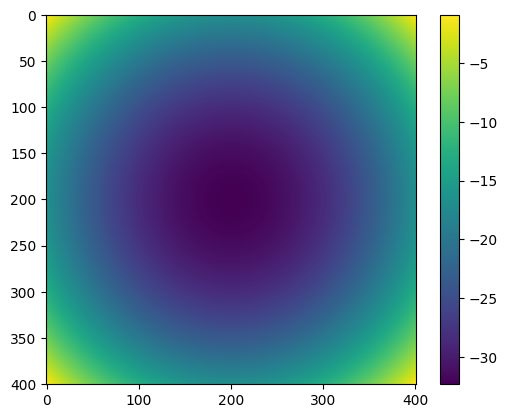

In [52]:
I_M = np.matrix([I1.flatten(), I2.flatten(), I3.flatten()]).transpose()
U_M = np.matrix([[1, 1, 1], 
                 [np.cos(0), np.cos(np.pi), np.cos(1.8*np.pi)],
                 [np.sin(0), np.sin(np.pi), np.sin(1.8*np.pi)]]).transpose()
V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1
phase_change_2 = np.arctan2(-V_M[:, 2], V_M[:, 1])
stop = abs(phase_change_2.mean())

criterion = 0.0001

while stop > criterion:
    V_M[:, 1] = np.cos(phase_change_2)
    V_M[:, 2] = -np.sin(phase_change_2)
    U_M = (((V_M.transpose() * V_M) ** -1) * V_M.transpose() * I_M).transpose()
    V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1
    phase_change_1 = np.arctan2(-V_M[:, 2], V_M[:, 1])
    
    V_M[:, 1] = np.cos(phase_change_1)
    V_M[:, 2] = -np.sin(phase_change_1)
    U_M = (((V_M.transpose() * V_M) ** -1) * V_M.transpose() * I_M).transpose()
    V_M = I_M * U_M * (U_M.transpose() * U_M) ** -1
    phase_change_2 = np.arctan2(-V_M[:, 2], V_M[:, 1])
    
    stop = abs((np.array(phase_change_2 - phase_change_1) ** 2).mean())
    print(stop)

recovered_phase = phase_change_2.reshape((401, -1))
recovered_phase = unwrap(recovered_phase)
plt.imshow(recovered_phase)
plt.colorbar()

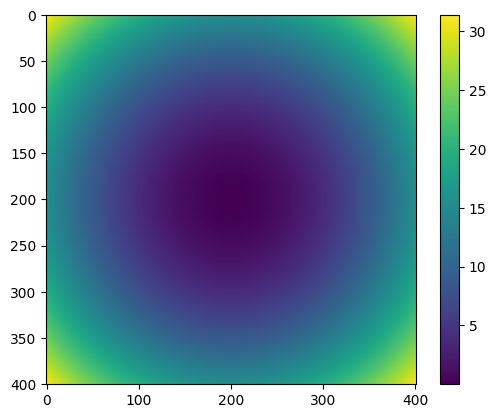

In [50]:
plt.imshow(fi)
plt.colorbar()